# **Creating a customer ranking system for insurance company**
##### A learning to rank cross-sell project

## **Insuricare and Business Problem**

<p align="justify"> Insuricare is an insurance company that has provided health insurance to its customers, and now they are willing to sell a new vehicle insurance to their clients. To achieve that, Insuricare conducted a research with around 305 thousand customers that bought the health insurance last year, asking each one if they would be interested in buying the new insurance. This data was stored in the company's database, alongside other customers' features. 

Then, Insuricare Sales Team selected around 76 thousand new customers, which are people that didn't respond to the research, to offer the new vehicle insurance. However, due to a limit call <i>restriction*</i> Insuricare must choose a way of selecting which clients to call: </p>

- Either select the customers randomly, which is our <b>baseline model</b>.
  
- Or, the Data Science Team will provide, by using a Machine Learning (ML) model, an ordered list of these new customers, based on their propensity score of buying the new insurance.

<i> * Insuricare Sales Team would like to make 20,000 calls, but it can be pushed to 40,000 calls. </i>

## 1. **Imports**

#### 1.1. **Libraries**

In [1]:
import pickle
import optuna
import numpy      as np
import pandas     as pd
import sqlalchemy as sql

import seaborn           as sns
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes

from IPython.display import Image
from dython.nominal  import cramers_v

from scikitplot.metrics      import plot_cumulative_gain, plot_lift_curve
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

from xgboost              import XGBClassifier
from lightgbm             import LGBMClassifier
from catboost             import CatBoostClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier, AdaBoostClassifier 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignoring Future Warnings
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#### 1.2. **Helper Functions**

In [2]:
def get_data_sql(username: str, 
                 pwd: str, 
                 host: str, 
                 port: str, 
                 database: str, 
                 query_table_users: str) -> pd.DataFrame:
    '''
    Extracts data from PostgreSQL.

    Parameters
    ----------
    username : str
    Username credential.

    pwd : str
    Password credential.

    host : str
    Host credential.

    port : str
    Port credential.

    database : str
    Database credential.

    query_table_users : str
    SQL query.
    
    Returns
    -------
    df_raw : pd.DataFrame
    Raw extracted dataframe. 
    ''' 
    credentials = f'postgresql://{username}:{pwd}@{host}:{port}/{database}' # passing the credentials
    db = sql.create_engine(credentials)
    conn = db.connect() # open connection
    df_raw = pd.read_sql(query_table_users, conn) # get data
    df_raw = df_raw.iloc[:, ~df_raw.columns.duplicated()] # drop duplicated id columns (col_index 5 and 9)
    df_raw = df_raw.drop_duplicates(subset=['id'], keep='first') # drop duplicated id rows
    conn.close() # close connection
    db.dispose()

    return df_raw

def data_shape(data: pd.DataFrame) -> None:
    '''
    Gets the number of rows and columns for a given data.

    Parameters
    ----------
    data : pd.DataFrame
    Data on which the function will be applied.
    
    Returns
    -------
    None 
    '''   
    print(f'Number of Rows: {data.shape[0]}')
    print(f'Number of Columns: {data.shape[1]}')

    return None  
 
def descriptive_statistics(num_attributes: pd.DataFrame) -> pd.DataFrame:
    '''
    Creates a descriptive statistics table.

    Parameters
    ----------
    num_attributes: pd.DataFrame    
    DataFrames's numerical attributes.    
    
    Returns
    -------
    metrics : pd.DataFrame
    Descriptive statistics table.
    '''
    # Central Tendency 
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Dispersion 
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    
    # Concat
    metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    metrics.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

    return metrics

def bar_plot(aux: pd.DataFrame, 
             x: str, 
             xlabel: str, 
             y: str, 
             ylabel: str, 
             figsize: tuple = (12, 8), 
             binned: bool = False) -> Axes:
    '''
    Plots both curves: Cumulative Gain and Lift.

    Parameters
    ----------
    aux : pd.DataFrame
    Filtered DataFrame.

    x : str
    x values.

    xlabel : str
    x label.

    y : str
    y values.

    ylabel : str
    y label.

    figsize : tuple
    Figsize parameters.

    binned : bool, default = False
    Plots with bins (rotates x axis and changes ticklabel_format).

    Returns
    -------
    ax : matplotlib.axes._axes.Axes
    Barplot.
    '''

    if binned:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        sns.barplot(x=x,y=y, data=aux);
        plt.xlabel(xlabel)
        plt.ylabel(ylabel);
        plt.xticks(rotation=90) # Rotating the x axis for better visualization 
        plt.ticklabel_format(style='plain', axis='y')
        return ax

    else:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        sns.barplot(x=x,y=y, data=aux);
        plt.xlabel(xlabel)
        plt.ylabel(ylabel);
        return ax

def cramers_matrix(cat: pd.DataFrame) -> None:   
    '''
    Calculates the Cramér's V correlation matrix.

    Parameters
    ----------
    cat: pd.DataFrame
    Categorical attributes from the data.
        
    Returns
    -------
    None 
    '''
    a1 = cramers_v(cat[cat.columns[0]], cat[cat.columns[0]])
    a2 = cramers_v(cat[cat.columns[0]], cat[cat.columns[1]])
    a3 = cramers_v(cat[cat.columns[1]], cat[cat.columns[0]])
    a4 = cramers_v(cat[cat.columns[1]], cat[cat.columns[1]])

    matrix = pd.DataFrame({'gender':      [a1, a2],
                           'vehicle_age': [a3, a4] })

    matrix = matrix.set_index(matrix.columns)
    
    plt.figure(figsize=(20,12))
    sns.heatmap(matrix, annot=True)
    plt.show()    

    return None     

def feature_importances(model: any, X_train_n: pd.DataFrame, y_train_n: np.array) -> None:
    '''
    Ranks the feature importances by using ensemble algorithms.

    Parameters
    ----------
    model : any (depends on the model)
    Ensemble model used (e.g. Random Forest, Decision Tree, ExtraTrees, etc).

    X_train_n : pd.DataFrame
    X train.

    y_train_n: np.array
    Y train.

    Returns
    -------
    None 
    '''
    # Fitting the model
    model.fit(X_train_n, y_train_n)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print feature ranking
    print("Feature Ranking:\n")
    df = pd.DataFrame()
    for i, j in zip(X_train_n, model.feature_importances_):
        aux = pd.DataFrame({'feature': i , 'importance': j}, index=[0])
        df = pd.concat([df, aux], axis=0)

    print(df.sort_values('importance', ascending=False))

    # Plot the ranked features by importance
    plt.title('Feature Importances')
    plt.bar(range(X_train_n.shape[1]), importances[indices], color="b", align="center")
    plt.xticks(range(X_train_n.shape[1]), indices)
    plt.xlim([-1, X_train_n.shape[1]])
    plt.show()

    return None

def precision_at_k(data: pd.DataFrame, k: int = 20000) -> pd.DataFrame:
    '''
    Calculates precision at k for a given data (fraction of correct predictions made until K out of all predictions).

    Parameters
    ----------
    data : pd.DataFrame
    Data used.

    k : int, default = 20000
    How far the precision goes in the data.

    Returns
    -------
    precision_at_k : pd.DataFrame
    '''
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def recall_at_k(data: pd.DataFrame, k: int = 20000) -> pd.DataFrame:
    '''
    Calculates recall at k for a given data (fraction of correct predictions made until K out of all true examples). 

    Parameters
    ----------
    data : pd.DataFrame
    Data used.

    k : int, default = 20000
    How far the recall goes in the data.

    Returns
    -------
    recall_at_k : pd.DataFrame
    '''
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k'] 
                          
def cross_validation(model: any, X_train: pd.DataFrame, y_train: pd.DataFrame, k: int, verbose: bool = True) -> pd.DataFrame:
    '''
    Splits the data into train and validation, fits the given model for each k_fold, 
    makes probability predictions and returns a DataFrame with the mean +/- std (of k models) for 
    two performance metrics: precision at k and recall at k. 

    Parameters
    ----------
    model : any (depends on the model)
    ML model used.

    X_train : pd.DataFrame
    X training data.

    y_train: pd.DataFrame
    Y training data.

    k : int
    Number of k folds.

    Returns
    -------
    DataFrame: pd.DataFrame
    Contains cross-validation precision at k and recall at k.
    '''
    # Number of k folds
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Empty list to store all metrics
    precision_k_list = [] 
    recall_k_list = []  
    i = 1
    
    for train_cv, val_cv in kfold.split(X_train, y_train):
        if verbose == True:    
            print(f'Fold Number {i}/{k}') 
        else:
            pass

        # Training dataset
        X_train_fold = X_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        # Validation dataset
        x_val_fold = X_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        # Model
        model.fit(X_train_fold, y_train_fold)

        # Prediction
        yhat_proba = model.predict_proba(x_val_fold)

        # Storing the performance of each kfold iteration
        data = pd.DataFrame()        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat_proba[:,1].tolist()
        
        data = data.sort_values('score',ascending=False)
        
        # Precision at K
        precision_k = precision_at_k(data)
        precision_k_list.append(precision_k)
        
        # Recall at K
        recall_k = recall_at_k(data)
        recall_k_list.append(recall_k)
        i = i + 1

    return pd.DataFrame({'Model': type(model).__name__,
                         'Precision at K': np.round(np.mean(precision_k_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_k_list),4).astype(str),
                         'Recall at K': np.round(np.mean(recall_k_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_k_list),4).astype(str)}, index=[0])

def model_eval(model: any, 
               X_train_ml: pd.DataFrame, 
               y_train_ml: np.array, 
               X_val: pd.DataFrame, 
               y_validation: pd.DataFrame, 
               k: int = 20000) -> pd.DataFrame:
    '''
    Evaluates the model by two metrics (precision at k and recall at k) without cross-validation.

    Parameters
    ----------
    model : any (depends on the model)
    ML model used.

    X_train_ml : pd.DataFrame
    X training data.

    y_train_ml: np.array
    Y training data.

    X_val : pd.DataFrame
    X validation data.

    y_validation : pd.DataFrame
    Y validation data.

    k : int, default = 20000
    How far the precision/recall goes in the data.

    Returns
    -------
    DataFrame: pd.DataFrame
    Contains model precision at k and recall at k. 
    '''
    # Fitting the model
    model.fit(X_train_ml, y_train_ml)
    yhat_proba = model.predict_proba(X_val)
    
    # Ranking and sorting
    data = pd.DataFrame()  
    data = X_val.copy()
    data['response'] = y_validation.copy()
    data['score'] = yhat_proba[:,1].tolist()    
    data = data.sort_values('score',ascending=False)

    # Precision at K
    precision_k = precision_at_k(data, k=k)

    # Recall at K
    recall_k = recall_at_k(data, k=k)

    return pd.DataFrame({'Model': type(model).__name__,
                         'Precision at K': round(precision_k,4),
                         'Recall at K': round(recall_k,4)}, index=[0])

def propensity_score(model: any, x_test_ml: pd.DataFrame, df_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Calculates the propensity score for a given dataset.

    Parameters
    ----------
    model : any (depends on the model)
    ML model used.

    x_test_ml : pd.DataFrame
    X test data.

    df_test: pd.DataFrame
    Raw test data.

    Returns
    -------
    ordered_list : pd.DataFrame
    List ordered by propensity score.
    '''
    # Removing response from df_test
    df_test = df_test.drop(columns=['response'],axis=1)

    # Propensity score prediction
    yhat_proba = model.predict_proba(x_test_ml)

    # Storing the performance
    data = pd.DataFrame()        
    data = x_test_ml.copy()
    data['score'] = yhat_proba[:,1].tolist()

    # Adding score to df_test and ordering the list
    df_test['score'] = data['score']
    ordered_list = df_test.sort_values('score', ascending=False)

    return ordered_list                         

def model_curves(model: any, 
                 X_train_ml: pd.DataFrame, 
                 y_train_ml: np.array, 
                 x_test: pd.DataFrame, 
                 y_test: pd.DataFrame, 
                 k: int = 20000, 
                 axh: float = 0.7129, 
                 axh_lift: float = 2.72) -> Axes:    
    '''
    Plots both curves: Cumulative Gain and Lift.

    Parameters
    ----------
    model : any (depends on the model)
    ML model used.

    X_train_ml : pd.DataFrame
    X training data.

    y_train_ml : np.array
    Y training data.

    x_test : pd.DataFrame
    X test data.

    y_test : pd.DataFrame
    Y test data.

    k : int, default = 20000
    Used to calculate data percentage.

    axh : float, default = 0.7129
    Horizontal line in cumulative gain curve.

    axh_lift : float, default = 2.72
    Horizontal line in lift curve.

    Returns
    -------
    ax : matplotlib.axes._axes.Axes
    Cumulative gain and lift curves plot.
    '''
    
    # Fitting the model
    model.fit(X_train_ml, y_train_ml)
    yhat_proba = model.predict_proba(x_test)

    # Data percentage
    data_pct = k/len(x_test)

    # Plotting both curves
    fig, ax = plt.subplots(1, 2, figsize=(18,9))  
    
    plot_cumulative_gain(y_test, yhat_proba, ax=ax[0])
    ax[0].axvline(data_pct, 0, 1, color='green', ls='--', lw=3)
    ax[0].axhline(axh, 0, 1, color='green', ls='--', lw=3)

    plot_lift_curve(y_test, yhat_proba, ax=ax[1])
    ax[1].axvline(data_pct, 0, 1, color='green', ls='--', lw=3)
    ax[1].axhline(axh_lift, 0, 1, color='green', ls='--', lw=3)
    plt.xlim(0.1,1)
    plt.ylim(0,3.5)

    return ax[0], ax[1]

#### 1.3. **Collecting Data**

In [3]:
# Credentials - (Ideally those would have to be hidden)
username = 'member'
pwd = 'cdspa'
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'

# Query
query_table_users = """
    SELECT *
    FROM pa004.users u LEFT JOIN pa004.vehicle   v on (u.id = v.id)
                       LEFT JOIN pa004.insurance i on (u.id = i.id)
"""

df_raw = get_data_sql(username, pwd, host, port, database, query_table_users)

## 2. **Data Descriptions**

In [4]:
df2 = df_raw.copy()

| **Feature**          | **Definition** |
|----------------------|----------------|
| id                   | Unique ID for the customer|
| gender               |Gender of the customer|
| age                  |Age of the customer|
| region_code          |   Unique code for the region of the customer|
| policy_sales_channel |Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc|
| driving_license      |0 : Customer does not have DL, 1 : Customer already has DL|
| vehicle_age          |Age of the Vehicle|
| vehicle_damage       |Yes : Customer got his/her vehicle damaged in the past. No : Customer didn't get his/her vehicle damaged in the past.|
| previously_insured   |1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance|
| annual_premium       |The amount customer needs to pay as premium in the year|
| vintage              |Number of Days, Customer has been associated with the company|
| response             | 1 : Customer is interested in the new insurance, 0 : Customer is not interested in the new insurance|

#### 2.1. **Data Dimensions**

In [5]:
data_shape(df2)

Number of Rows: 381109
Number of Columns: 12


#### 2.2. **Data Types**

In [6]:
df2.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

The following columns will have to go through encoding:
- region_code
- policy_sales_channel
- gender
- vehicle_age
- vehicle_damage

In [7]:
# Both policy_sales_channel and region_code will be transformed to object type, so that when those go through encoding the encoding method can identify them as categorical variables.
df2['region_code'] = df2['region_code'].astype(str)
df2['policy_sales_channel'] = df2['policy_sales_channel'].astype(str)

#### 2.3. **Check NaN's**

In [8]:
df2.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

No NaN's are present in the data.

#### 2.4. **Descriptive Statistics**

In [9]:
# Getting only the numerical attributes
num_attributes = df2.select_dtypes(include=['int64', 'float64']).drop(columns=['id'],axis=1)

# Descriptive Statistics
descriptive_statistics(df2, num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.00000,85.00000,65.00000,38.82258,36.00000,15.51159,0.67254,-0.56566
1,driving_license,0.00000,1.00000,1.00000,0.99787,1.00000,0.04611,-21.59518,464.35430
2,previously_insured,0.00000,1.00000,1.00000,0.45821,0.00000,0.49825,0.16775,-1.97187
3,annual_premium,2630.00000,540165.00000,537535.00000,30564.38958,31669.00000,17213.13247,1.76609,34.00457
4,vintage,10.00000,299.00000,289.00000,154.34740,154.00000,83.67119,0.00303,-1.20069
5,response,0.00000,1.00000,1.00000,0.12256,0.00000,0.32794,2.30191,3.29879


#### **Train Test Split**

To understand why the train-test split is being done early on, it's firstly important to understand the meaning of **Data Leakage** in Data Science. Data Leakage can occur whenever a transformation is applied to the entire dataset before splitting the dataset in train and test, because unexpected extra information can be leaked into the test dataset. For instance, if target encoding is performed before the data split an important information is leaked into the test dataset, since this transformation replaces a categorical value with the mean of the target variable. 

For this instance, the test dataset represents the 76 thousand new customers (20% of the entire dataset), on which the sales teams wish to get a ranked list.

In [10]:
# Test Dataset Extraction
X = df2.drop(columns=['response'], axis=1).copy()
y = df2['response'].copy()

x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify = y,
                                                    test_size=0.2,
                                                    random_state=42)

df_train = pd.concat([x_train, y_train], axis = 1) # 305k customers - this will be used throughout the project

df_test = pd.concat([x_test, y_test], axis = 1) # 76k new customers

In [11]:
data_shape(df_train) # train shape - 305k customers

Number of Rows: 304887
Number of Columns: 12


In [12]:
data_shape(df_test) # test shape - 76k new customers

Number of Rows: 76222
Number of Columns: 12


## 3. **Feature Engineering**

In [13]:
df3 = df_train.copy()

#### 3.1. **Hypotheses Mindmap**

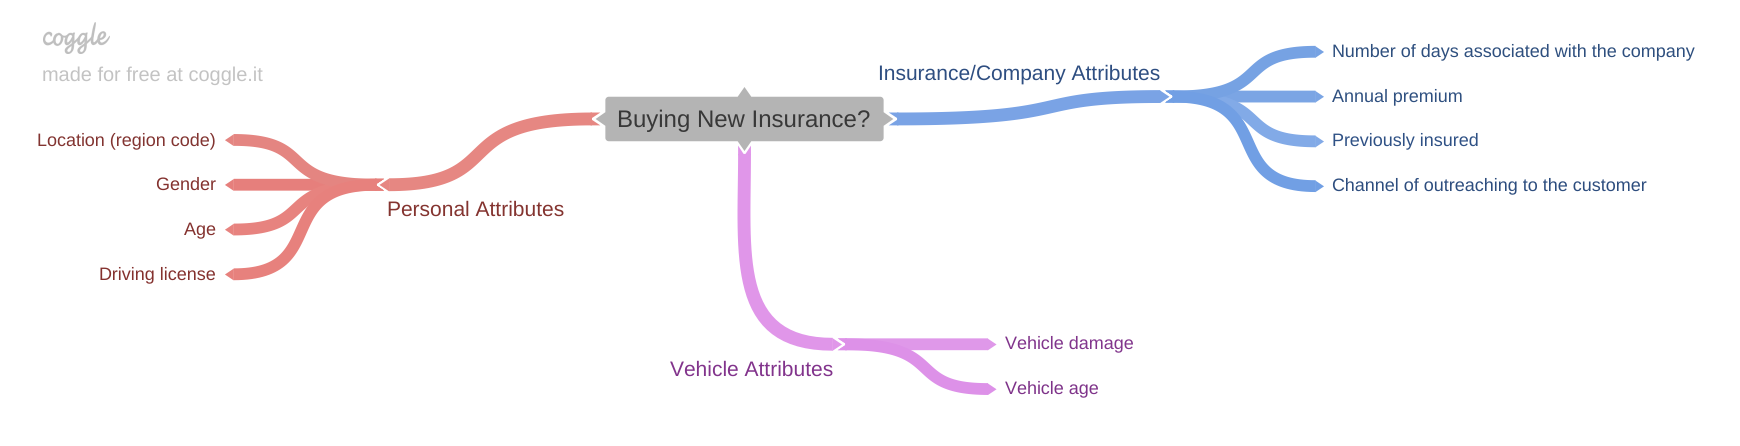

In [14]:
Image('C:/Users/bruno/OneDrive/Documentos/repos/pa-health-insurance-cross-sell/images/insurance.png', width=1250)

#### 3.2. **Hypotheses Creation**

3.2.1. **Personal Attributes Hypotheses**

- **H1:** Customers that have a driving license are more likely to buy the new vehicle insurance.
- **H2:** Customers in some locations are more likely to buy the new vehicle insurance, given the robbery rate, crash accidents occurrences, etc.
- **H3:** Older customers are more likely to buy the new vehicle insurance.
- **H4:** Women are more likely to buy the new vehicle insurance than men.

3.2.2. **Vehicle Attributes Hypotheses**

- **H1:** Customers with newer vehicles are more likely to buy vehicle insurance.
- **H2:** Customers that got their vehicle damaged in the past are more likely to buy the new vehicle insurance.

3.2.3. **Insurance/Company Attributes Hypotheses**

- **H1:** Customers that already have vehicle insurance are less likely to buy the new vehicle insurance.
- **H2:** Customers with lower annual premium are more likely to buy the new vehicle insurance.
- **H3:** Customers that have been in the company for a longer period are more likely to buy the new vehicle insurance.
- **H4:** Customers that have been reached out by some specific channels are more likely to buy the new vehicle insurance.

<p align="justify"> Unfortunately, there's no information regarding what each sales outreach channel is linked with each number. Also, there's no information on regions' robbery rate and crash accidents occurrences, etc. Therefore, 3.2.1 H2 and 3.2.3 H4 were dropped. </p>

#### 3.3. **Final Hypotheses List**

- **H1:** Customers that have a driving license are more likely to buy the new vehicle insurance.
- **H2:** Older customers are more likely to buy the new vehicle insurance.
- **H3:** Customers with newer vehicles are more likely to buy vehicle insurance.
- **H4:** Women are more likely to buy the new vehicle insurance than men.
- **H5:** Customers that got their vehicle damaged in the past are more likely to buy the new vehicle insurance.
- **H6:** Customers that already have vehicle insurance are less likely to buy the new vehicle insurance.
- **H7:** Customers with lower annual premium are more likely to buy the new vehicle insurance.
- **H8:** Customers that have been in the company for a longer period are more likely to buy the new vehicle insurance.

#### 3.4. **Editing Features**

In [16]:
df3['vehicle_damage'] = df3['vehicle_damage'].apply(lambda x: 0 if x=='No' 
                                                                else 1) # Replacing Yes/No -> 1/0

## 4. **Feature Filtering**

In [17]:
df4 = df3.copy()

<p align="justify"> There's no need to filter rows or columns for this dataset as nothing unusual has been found to the point that it wouldn't make sense business-wise. </p>

## 5. **Exploratory Data Analysis (EDA)**

EDA main objectives are:
- Obtain business experience.
- Validate business hypotheses (insights).
- Find important features for the ML model. 

In [18]:
df5 = df4.copy()

#### 5.1. **Univariate Analysis**

5.1.1. **Response Variable**

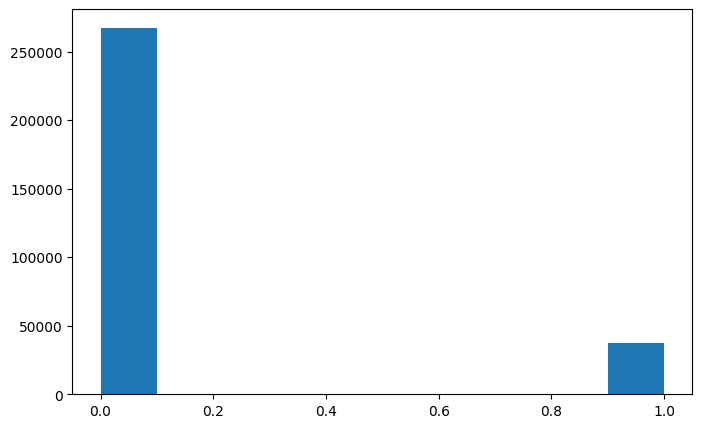

In [19]:
plt.figure(figsize=(8,5))
plt.hist(df5['response']);

In [20]:
buy = df5['response'].value_counts()[1]/len(df5['response'])*100

print(f'Only {round(buy,2)}% of customers database are willing to buy the new vehicle insurance.')

Only 12.26% of customers database are willing to buy the new vehicle insurance.


5.1.2. **Numerical Variables**

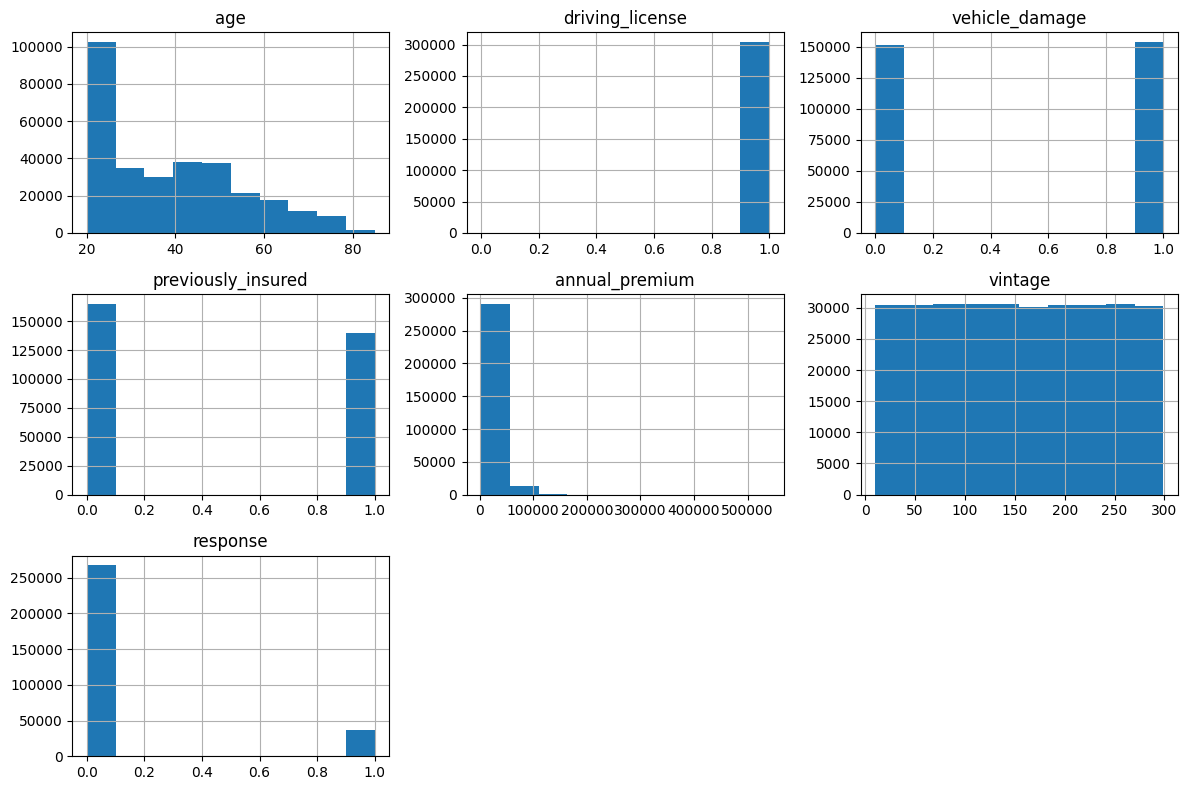

In [21]:
# Histogram plot for all numerical variables
num_attributes_new = df5.select_dtypes(include=['int64', 'float64']).drop(columns=['id'],axis=1)
num_attributes_new.hist(figsize=(12,8));
plt.tight_layout()
plt.show()

In [22]:
age_20_25 = len(df5[(df5['age']>=20)&(df5['age']<=25)]) # Age from 20-25
region_code_28 = len(df5[df5['region_code']==28]) # Region code 28
sales_channel_152 = len(df5[df5['policy_sales_channel']==152]) # Sale channel 152
driving_license_1 = len(df5[df5['driving_license']==1]) # Driving license
premium_2k_to_40k = len(df5[(df5['annual_premium']>=2630)&(df5['annual_premium']<=40000)]) # Annual premium from 2k to 40k

print(f'People from 20 to 25 years old = {round(age_20_25/len(df5),2)*100}%')
print(f'People in region code 28 = {round(region_code_28/len(df5),4)*100}%')
print(f'Sales channel 152 = {round(sales_channel_152/len(df5),2)*100}%')
print(f'People that own a driving license = {round(driving_license_1/len(df5),4)*100}%')
print(f'People with premiums from 2k to 40k per year = {round(premium_2k_to_40k/len(df5),3)*100}%')

People from 20 to 25 years old = 30.0%
People in region code 28 = 0.0%
Sales channel 152 = 0.0%
People that own a driving license = 99.79%
People with premiums from 2k to 40k per year = 76.4%


- 30% of people are 20 to 25 years old in the dataset.
- About 28% of people are located at region 28.
- Sales channel 152 represents about 1/3 of customers outreach.
- Almost everyone in the dataset own a driving license.
- Over 3/4 of people have their annual premiums set at US$ 2,630 (min) to around US$ 40,000.

5.1.3. **Categorical Variables**

There're only two categorical variables to explore:
- Gender
- Vehicle Age 

<p align="justify"> <i> Even though Vehicle Age is numerical, for this particular dataset, I'll be considering it as categorical for now, since it didn't go through any encoding transformation yet. </i> </p>

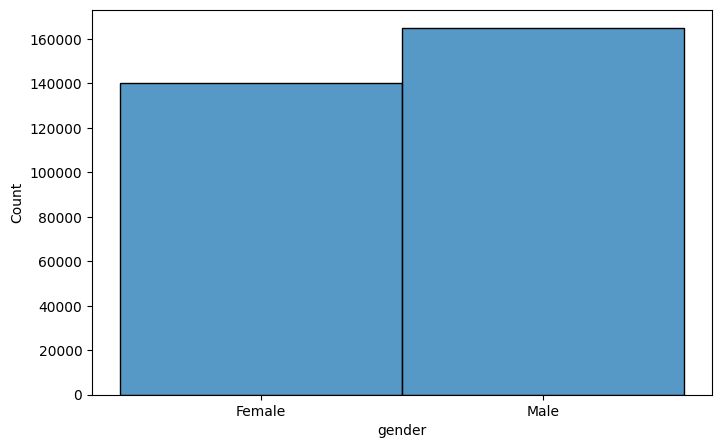

In [23]:
plt.figure(figsize=(8,5))
sns.histplot(data=df5, x='gender');

In [24]:
men_perc = df5['gender'].value_counts()[0]/len(df5)*100

print(f'About {round(men_perc,2)}% of the dataset is composed of men.')

About 54.06% of the dataset is composed of men.


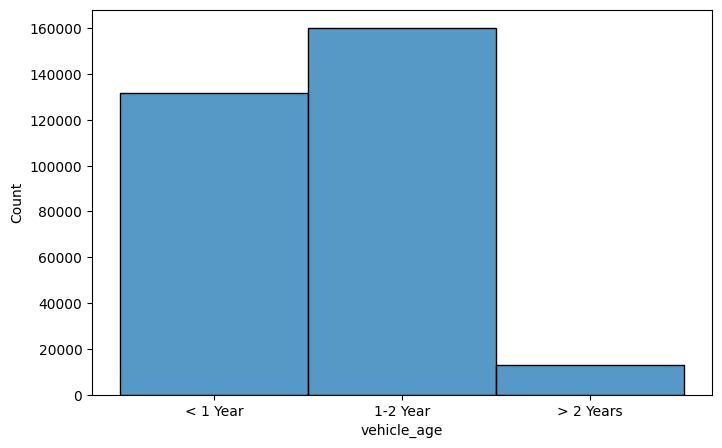

In [25]:
plt.figure(figsize=(8,5))
sns.histplot(data=df5, x='vehicle_age');

In [26]:
age_below_2 = (len(df5) - df5['vehicle_age'].value_counts()[2])/(len(df5))*100

print(f'About {round(age_below_2,2)}% of vehicles are less than 2 years old.')

About 95.8% of vehicles are less than 2 years old.


- There's slightly more men than women in the dataset.
- Only 5% of vehicles are older than two years.

#### 5.2. **Bivariate Analysis (Checking Hypotheses)**

##### **H1:** Customers that have a driving license are more likely to buy the new vehicle insurance.
**TRUE**: Customers that have a driving license are more likely to buy the new vehicle insurance.

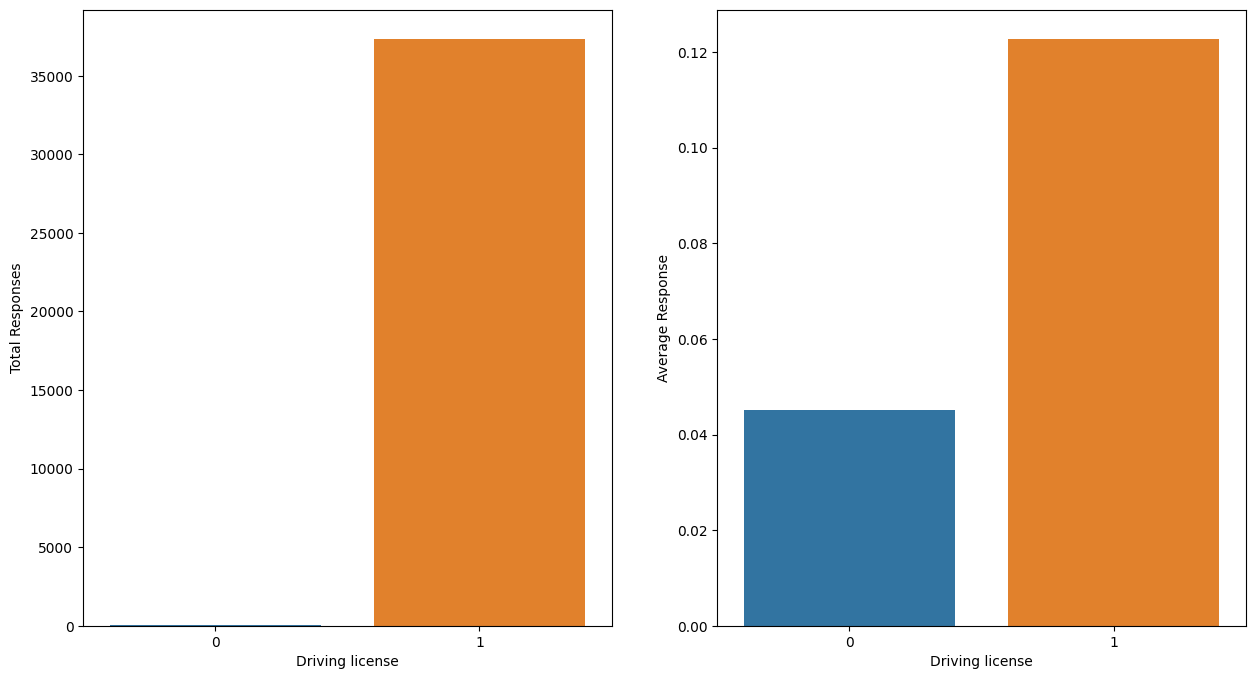

In [27]:
aux = df5[['response','driving_license']].groupby('driving_license').sum().reset_index()
aux2 = df5[['response','driving_license']].groupby('driving_license').mean().reset_index()

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.barplot(x='driving_license',y='response', data=aux);
plt.xlabel('Driving license')
plt.ylabel('Total Responses');

plt.subplot(1,2,2)
sns.barplot(x='driving_license',y='response', data=aux2);
plt.xlabel('Driving license')
plt.ylabel('Average Response');

##### **H2:** Older customers are more likely to buy the new vehicle insurance.

**TRUE**: Older customers are more likely to buy the new vehicle insurance.

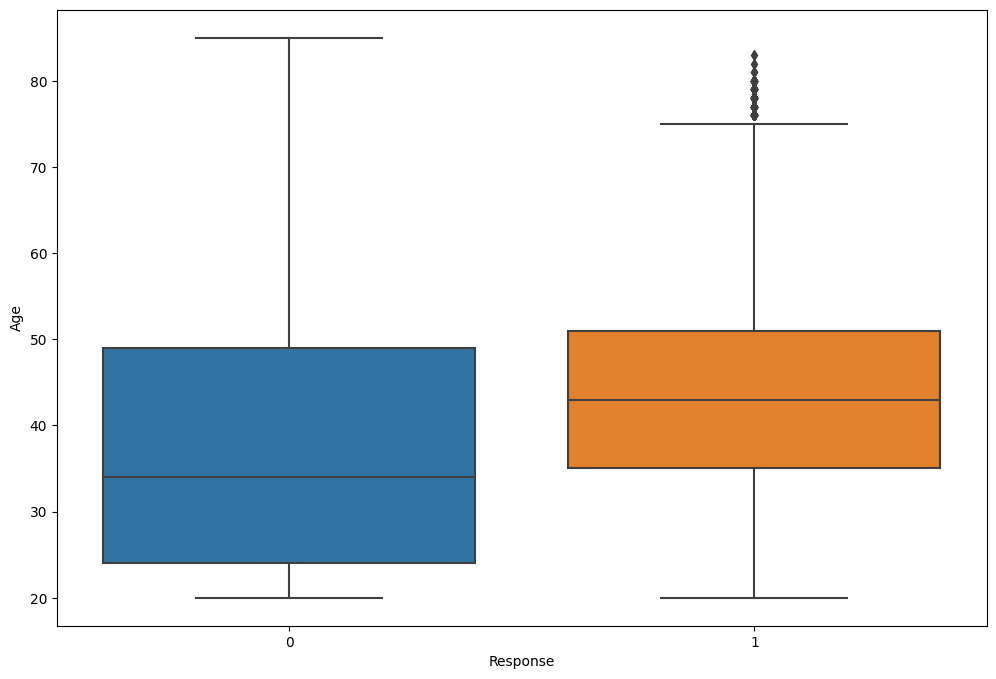

In [28]:
plt.figure(figsize=(12,8))
sns.boxplot(x='response',y='age', data=df5);
plt.xlabel('Response')
plt.ylabel('Age');

##### **H3:** Customers with newer vehicles are more likely to buy vehicle insurance.

**FALSE**: Customers with older vehicles are more likely to buy vehicle insurance.

<AxesSubplot: xlabel='Vehicle Age', ylabel='Average Response'>

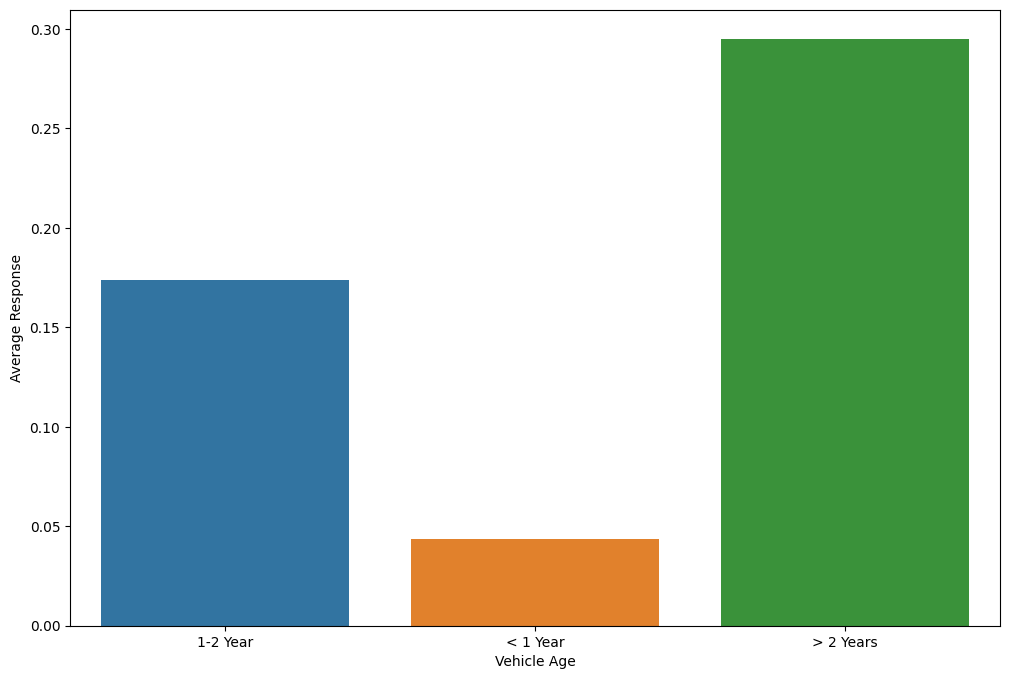

In [29]:
aux = df5[['vehicle_age','response']].groupby('vehicle_age').mean().reset_index()
bar_plot(aux, 'vehicle_age', 'response', 'Vehicle Age', 'Average Response')

The average response was used here, due to major differences in the amount of people in each vehicle age range.

##### **H4:** Women are more likely to buy the new vehicle insurance than men.

**FALSE**: Men are more likely to buy the new vehicle insurance than women.

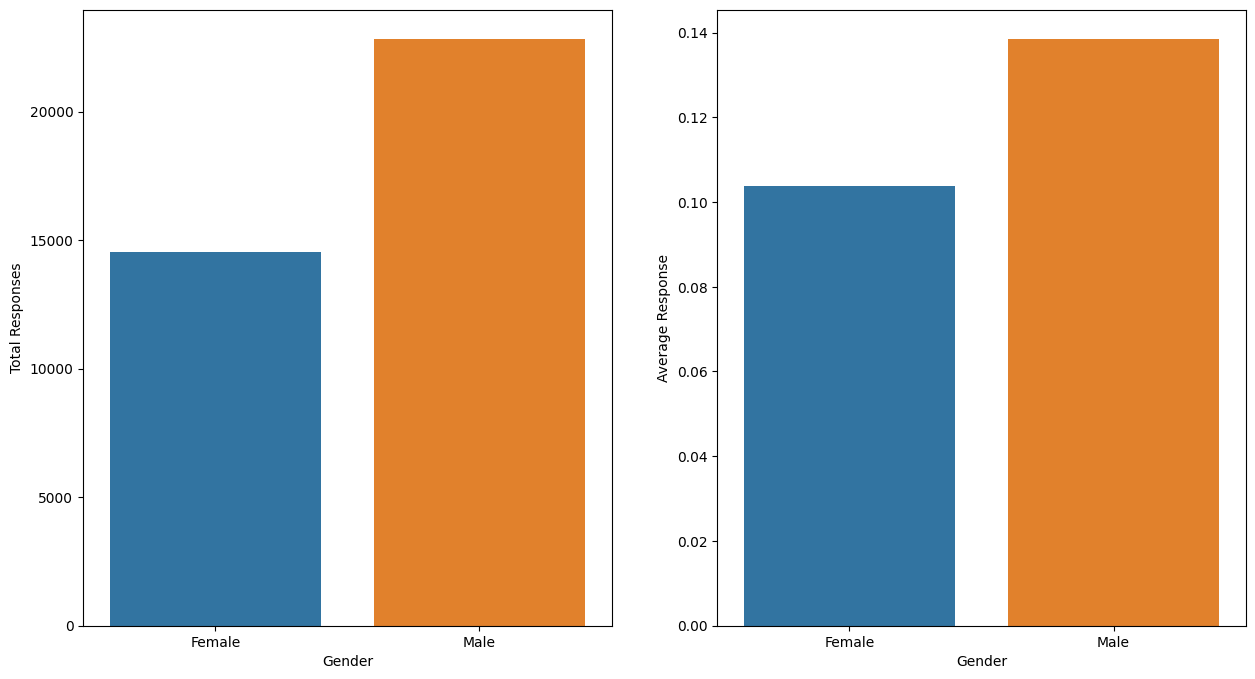

In [30]:
aux = df5[['response','gender']].groupby('gender').sum().reset_index()
aux2 = df5[['response','gender']].groupby('gender').mean().reset_index()

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.barplot(x='gender',y='response', data=aux);
plt.xlabel('Gender')
plt.ylabel('Total Responses');

plt.subplot(1,2,2)
sns.barplot(x='gender',y='response', data=aux2);
plt.xlabel('Gender')
plt.ylabel('Average Response');

##### **H5:** Customers that got their vehicle damaged in the past are more likely to buy the new vehicle insurance.

**TRUE**: Customers that got their vehicle damaged in the past are more likely to buy the new vehicle insurance.

<AxesSubplot: xlabel='Vehicle damaged in the past', ylabel='Total Responses'>

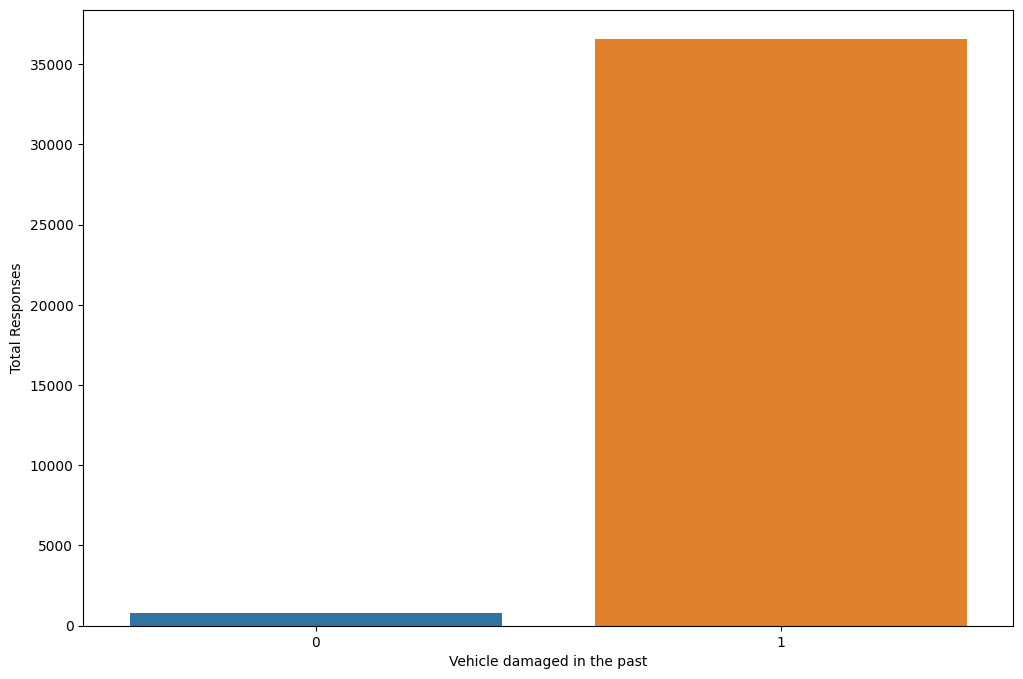

In [31]:
aux = df5[['vehicle_damage', 'response']].groupby('vehicle_damage').sum().reset_index()
bar_plot(aux, 'vehicle_damage', 'response', 'Vehicle damaged in the past', 'Total Responses')

##### **H6:** Customers that already have vehicle insurance are less likely to buy the new vehicle insurance.

**TRUE**: Only 0.34% of people that want the new insurance already have another vehicle insurance.

<AxesSubplot: xlabel='Previously Insured', ylabel='Total Responses'>

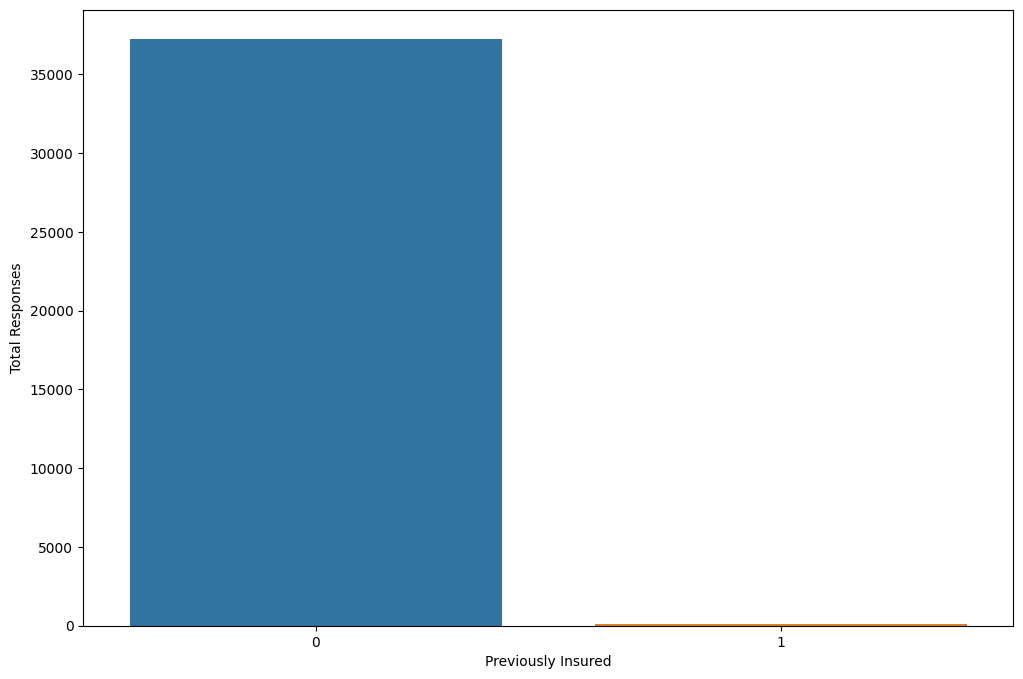

In [32]:
aux = df5[['previously_insured', 'response']].groupby('previously_insured').sum().reset_index()
bar_plot(aux, 'previously_insured', 'response', 'Previously Insured', 'Total Responses')

In [33]:
prev_perc = aux['response'][0]/aux['response'].sum()

print(f'Amount of people that want the new vehicle insurance buy already have another vehicle insurance = {round((1 - prev_perc)*100,2)}%')

Amount of people that want the new vehicle insurance buy already have another vehicle insurance = 0.32%


##### **H7:** Customers with lower annual premium are more likely to buy the new vehicle insurance.

**FALSE**: There's no clear relation between annual premium cost and average response per range.

<AxesSubplot: xlabel='Annual Premium', ylabel='Average Responses'>

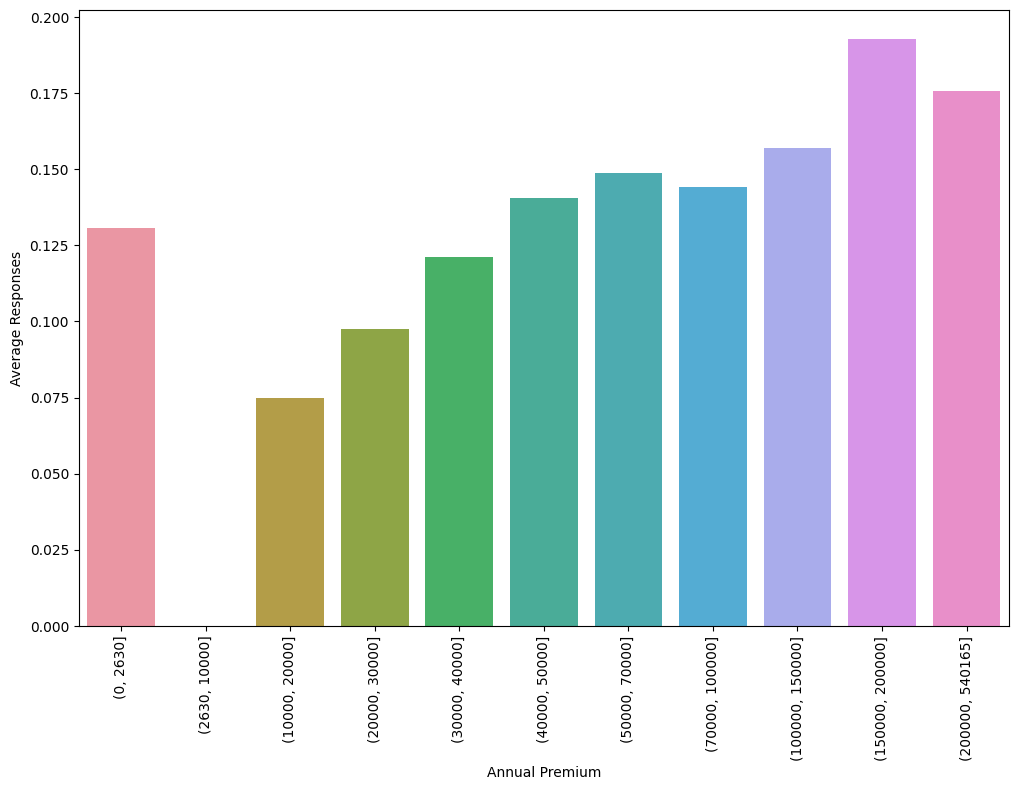

In [34]:
aux = df5[['annual_premium', 'response']].groupby('annual_premium').mean().reset_index()
bins = [0, 2630, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 150000, 200000, 540165] # Setting the barplot bins
aux['annual_premium_binned'] = pd.cut(aux['annual_premium'], bins=bins)
aux = aux[['annual_premium_binned','response']].groupby('annual_premium_binned').mean().reset_index()

bar_plot(aux, 'annual_premium_binned', 'response', 'Annual Premium', 'Average Responses', binned=True)

The average response was used here, due to major differences in the amount of people in each annual premium range.

##### **H8:** Customers that have been in the company for a longer period are more likely to buy the new vehicle insurance.

**FALSE**: There's no clear relation between how long a customer has been in the company and response per range.

<AxesSubplot: xlabel='Period in the company', ylabel='Total Responses'>

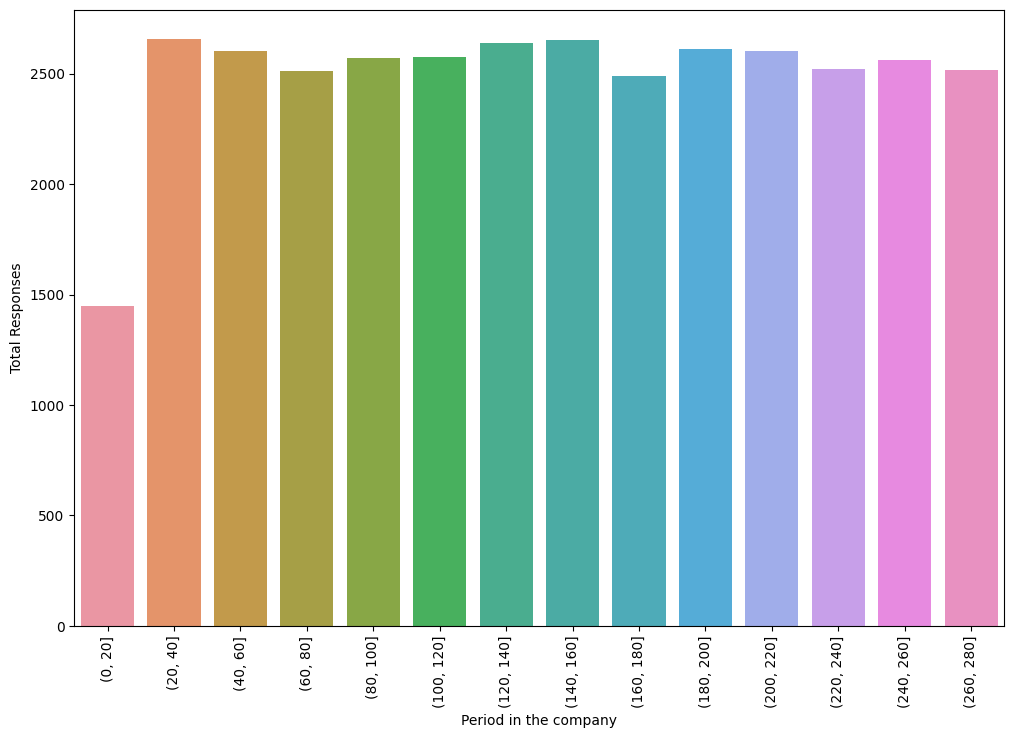

In [35]:
aux = df5[['vintage','response']].groupby('vintage').sum().reset_index()
bins = list(np.arange(0,300,20)) # Setting the barplot bins
aux['vintage_binned'] = pd.cut(aux['vintage'], bins=bins)
aux = aux[['vintage_binned','response']].groupby('vintage_binned').sum().reset_index()

bar_plot(aux, 'vintage_binned', 'response', 'Period in the company', 'Total Responses', binned=True)

5.2.1. **Hypotheses Summary**

| **Hypothesis** |    **Variable**    | **Hypothesis Conclusion** | **Expected Relevance** |
|:--------------:|:------------------:|:-------------------------:|:----------------------:|
| H1             | driving_license    | True                      | High                   |
| H2             | age                | True                      | Medium                 |
| H3             | vehicle_age        | False                     | Medium                 |
| H4             | gender             | False                     | Medium                 |
| H5             | vehicle_damage     | True                      | High                   |
| H6             | previously_insured | True                      | High                   |
| H7             | annual_premium     | False                     | Low                    |
| H8             | vintage            | False                     | Low                    |

<p align="justify"> Obs: <b>Expected Relevance</b> represents the ESTIMATED importance of each hypothesis for the algorithm. This estimation is purely based on business knowledge, as well as in the above analysis. For some hypotheses the estimated relevance could be wrong (when evaluating the fitted model). </p>

#### 5.3. **Multivariate Analysis**

5.3.1. **Numerical Variables**

In order to check correlation between all numerical variables in the dataset a pearson correlation will be displayed below:

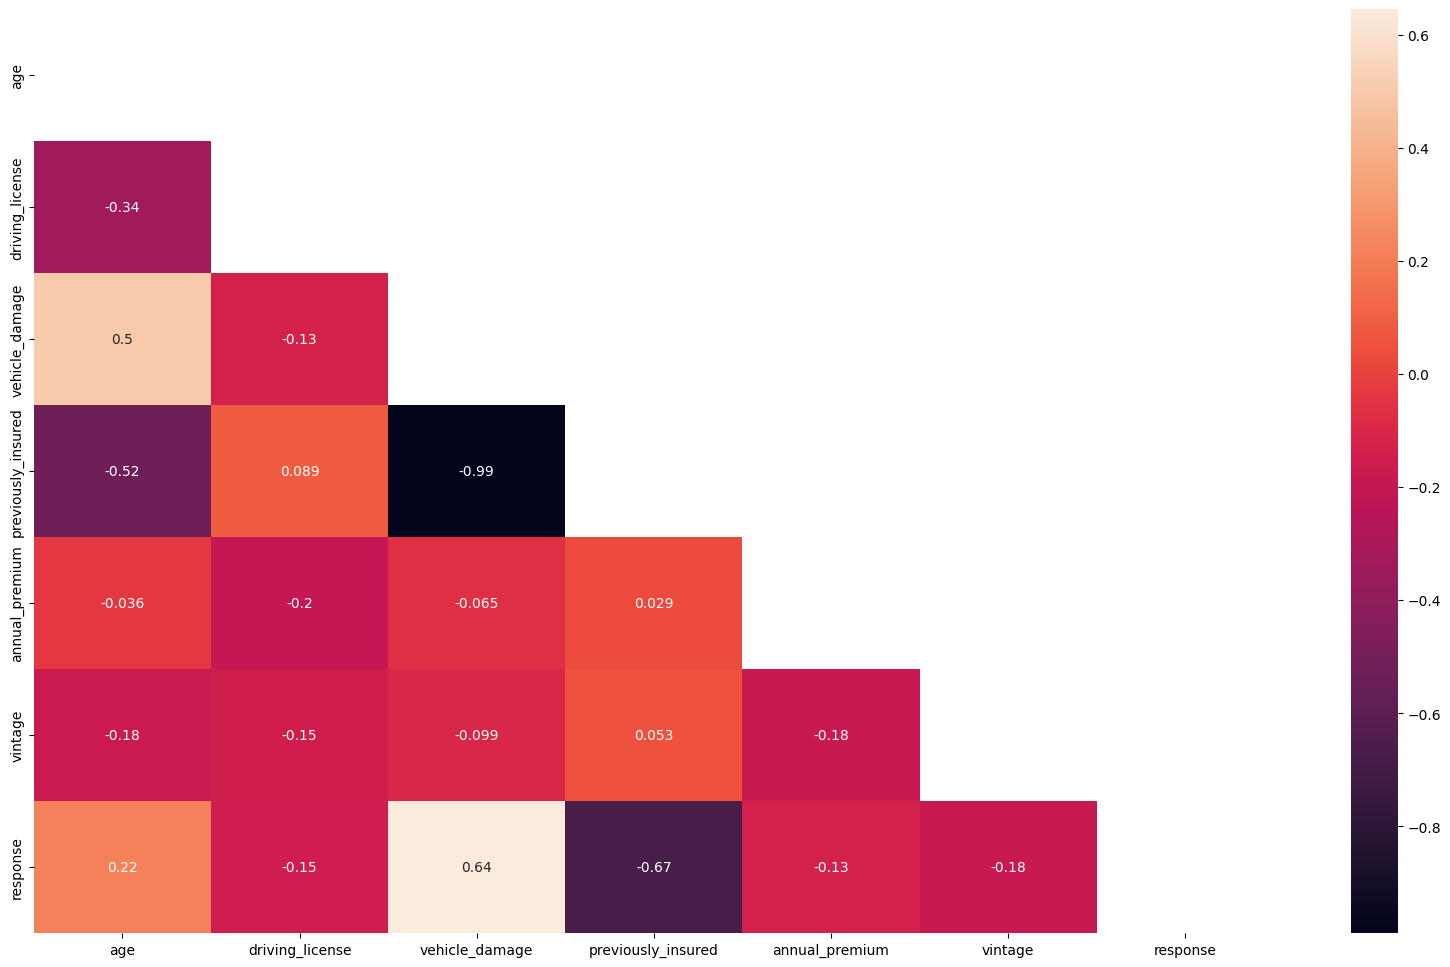

In [36]:
corr = num_attributes_new.corr(method='pearson').corr() # Pearson Corr
mask = np.triu(corr) # Cleaner heatmap - Only plotting the lower triangle

plt.figure(figsize=(20,12)) # Heatmap size
sns.heatmap(corr, annot=True, mask=mask);

5.3.2. **Categorical Variables**

<p align="justify"> In order to check correlation between all categorical variables (gender and vehicle_age) in the dataset a Cramér's V correlation matrix will be displayed below: </p>

In [37]:
df5.dtypes

id                        int64
gender                   object
age                       int64
region_code              object
policy_sales_channel     object
driving_license           int64
vehicle_age              object
vehicle_damage            int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

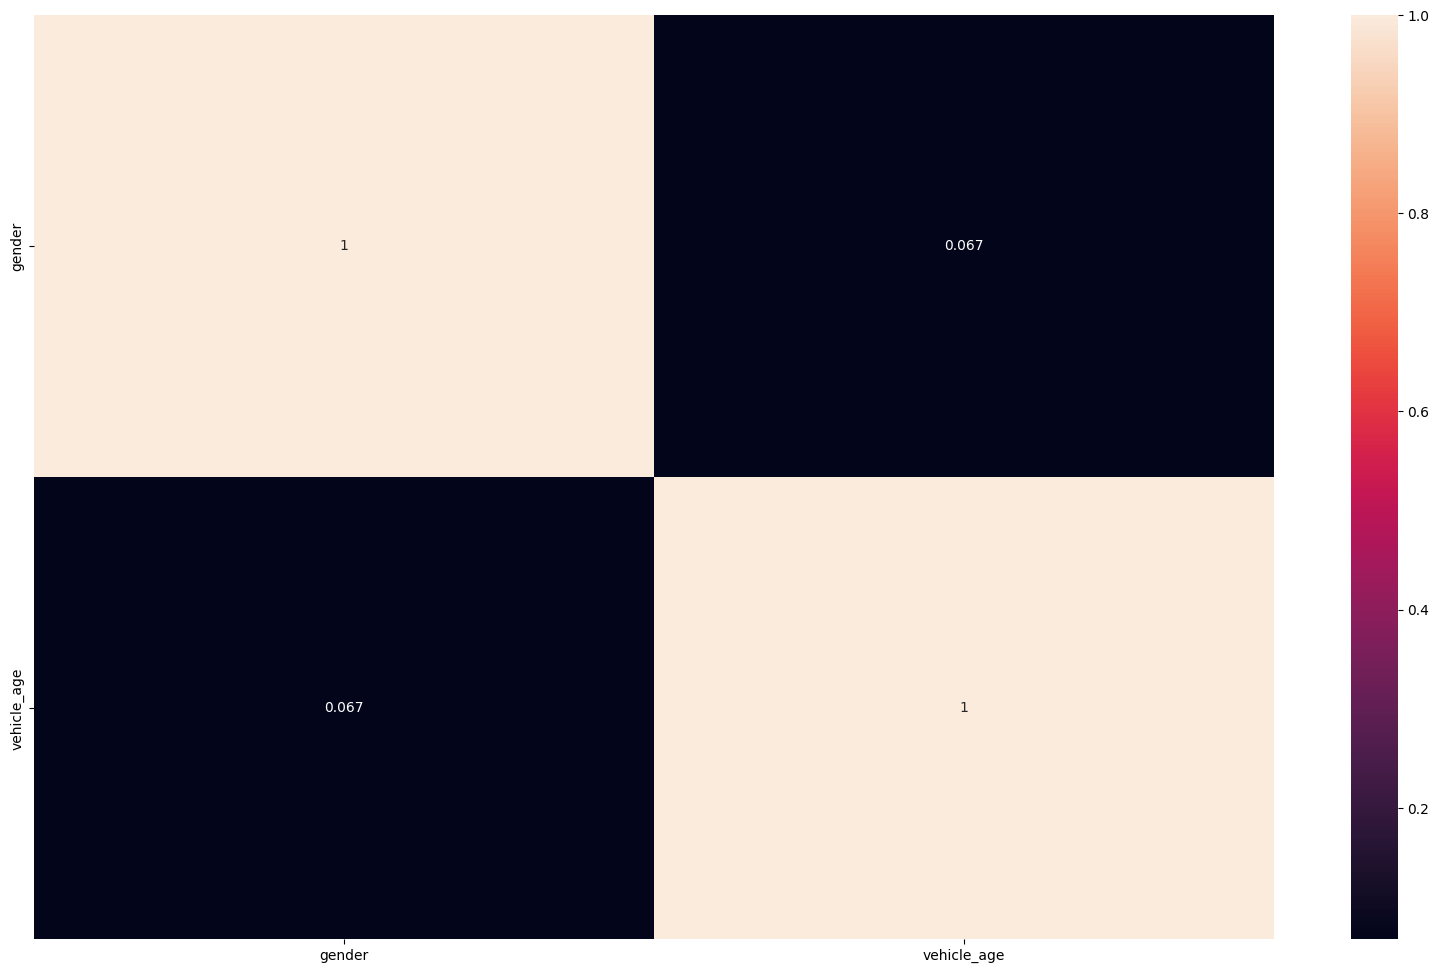

In [38]:
cat = df5.select_dtypes(include='object') # Select only categorical data
cramers_matrix(cat)

## 6. **Data Preparation**

In [39]:
df6 = df5.copy()

**Variables that will be rescaled**:
- age
- vintage
- annual_premium

**Variables that will be encoded**:
- gender
- region_code
- vehicle_age
- policy_sales_channel

**Variables that will remain the same, because those are already binary**:
- driving_license
- vehicle_damage
- previously_insured
- response

#### 6.1. **Rescaling**

<p align="justify"> The selected rescaling methods for this dataset are: Robust Scaler and Min Max Scaler. Robust Scaler is mostly used to deal with outliers, its formula is: </p>

${x}' =  \frac{x_{i} - Q_{1}(x)}{Q_{3}(x)- Q_{1}(x)}$

Whereas Min Max Scaler can be used when no significant outliers are present:

${x}' =  \frac{x - x_{min}}{x_{max} - x_{min}}$

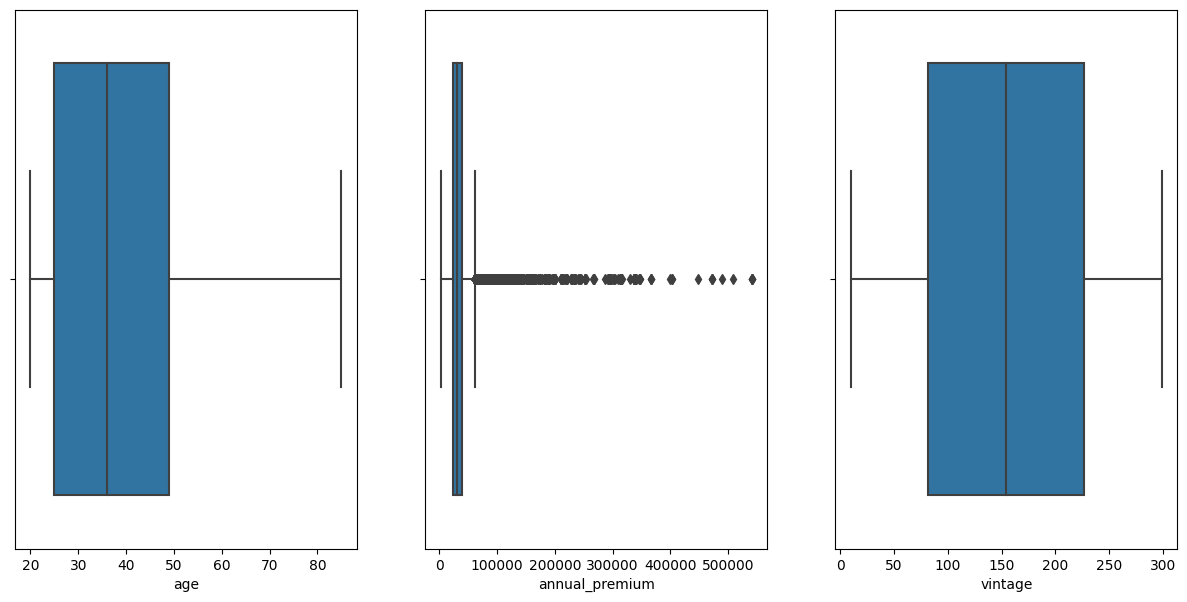

In [40]:
# Numerical variables boxplot
plt.figure(figsize=(15,7))            

plt.subplot(1,3,1)
sns.boxplot(x = df6['age'], orient='h')

plt.subplot(1,3,2)
sns.boxplot(x = df6['annual_premium'], orient='h')

plt.subplot(1,3,3)
sns.boxplot(x = df6['vintage'], orient='h');

Robust Scaler will be used for the annual_premium variable, whereas for age and vintage Min Max Scaler will be applied.

In [41]:
# age - MinMaxScaler
mms_age = MinMaxScaler()
df6['age'] = mms_age.fit_transform(df6[['age']].values)
pickle.dump(mms_age, open('scalers/age_scaler.pkl', 'wb')) # Saving for deployment

# vintage - MinMaxScaler
mms_vintage = MinMaxScaler()
df6['vintage'] = mms_vintage.fit_transform(df6[['vintage']].values)
pickle.dump(mms_vintage, open('scalers/vintage_scaler.pkl', 'wb'))  # Saving for deployment

# RobustScaler - annual_premium
rs = RobustScaler()
df6['annual_premium'] = rs.fit_transform(df6[['annual_premium']].values)
pickle.dump(rs, open('scalers/annual_premium_scaler.pkl', 'wb'))  # Saving for deployment

#### 6.2. **Encoding**

6.2.1. **One Hot Encoding - gender and vehicle_age**

<p align="justify"> One hot encoding creates n columns based on n labels present in the original column, assigning binary values to each new column. </p>

In [42]:
# gender
df6 = pd.get_dummies(df6, prefix=['gender'], columns=['gender']).rename(columns={'gender_Female': 'female', 'gender_Male': 'male'})

# vehicle_age
df6 = pd.get_dummies(df6, prefix=['vehicle_age'], columns=['vehicle_age']).rename(columns={'vehicle_age_< 1 Year' : 'v_age_below_1_year', 'vehicle_age_1-2 Year': 'v_age_between_1_2_years', 'vehicle_age_> 2 Years': 'v_age_above_2_years'})

6.2.2. **Target Encoding - policy_sales_channel and region_code**

Target encoding is the process of replacing a categorical value with the mean of the target variable. 

In [43]:
# region code 
te_region_code = df6.groupby('region_code')['response'].mean()
df6 = df6.assign(region_code=df6['region_code'].map(te_region_code))
pickle.dump(te_region_code, open('scalers/region_code_scaler.pkl', 'wb')) # Saving for deployment

# policy_sales_channel
te_policy_sales_channel = df6.groupby('policy_sales_channel')['response'].mean()
df6 = df6.assign(policy_sales_channel=df6['policy_sales_channel'].map(te_policy_sales_channel))
pickle.dump(te_policy_sales_channel, open('scalers/policy_sales_channel_scaler.pkl', 'wb')) # Saving for deployment

## 7. **Feature Selection**

In [44]:
df7 = df6.copy()

#### 7.1. **Split dataframe into training and validation dataset**

From the modified training dataset (df7) we'll be splitting this data into training and validation, for feature selection and ML modeling.

In [45]:
X = df7.drop(columns=['response', 'id'], axis=1).copy() # Removing the id for training the RF
y = df7['response'].copy()

x_train, x_validation, y_train, y_validation = train_test_split(X, 
                                                                y, 
                                                                stratify = y, 
                                                                test_size= 0.20, # Using 20% for validation
                                                                random_state = 42)

#### 7.2. **Random Forest as a Feature Selector**


<p align="justify"> Random Forest (RF) implements bagging method and decision trees, by resampling a random subset of the features and fitting each subset by using a decision tree. Finally, the most voted class for each observation is chosen as the RF prediction. Due to its nature, RF is often used as a feature selector, since each tree calculates the importance of a feature according to its power in increasing leaves' pureness.

A function named <b>feature_importances</b> was created in order to provide a list and a plot of ranked importances, given by the chosen model (RF in this case). 

<i> The function description is available at 1.2. Helper Functions section. </i> </p>

In [46]:
X_train_n = x_train.copy() 
y_train_n = y_train.values # Getting the y_train as an array

Feature Ranking:

                   feature  importance
0                  vintage     0.27782
0           annual_premium     0.24760
0                      age     0.15213
0              region_code     0.10107
0     policy_sales_channel     0.08119
0           vehicle_damage     0.06736
0       previously_insured     0.05219
0       v_age_below_1_year     0.00735
0  v_age_between_1_2_years     0.00455
0                   female     0.00297
0                     male     0.00295
0      v_age_above_2_years     0.00227
0          driving_license     0.00054


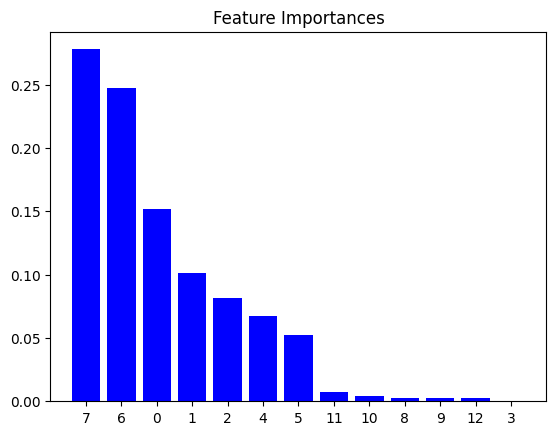

In [47]:
# Defining the RF model
rf = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)

# Using the feature_importances function
feature_importances(rf, X_train_n, y_train_n)

#### 7.3. **Selecting the Features**

Considering all features above 5%, seven were selected.

In [48]:
cols_selected = ['vintage',
                 'annual_premium',
                 'age',
                 'region_code',
                 'policy_sales_channel',
                 'vehicle_damage',
                 'previously_insured']

**Expectation vs Reality** considering what was expected on the 5.2.1. section (Hypotheses Summary) regarding features relevance:


| **Hypothesis** |    **Variable**    | **Hypothesis Conclusion** | **Expected Relevance** | **Relevant based on RF model?** |
|:--------------:|:------------------:|:-------------------------:|:----------------------:|:-------------------------------:|
|       H1       |   driving_license  |            True           |         High           |               No                |
|       H2       |         age        |            True           |         Medium         |               Yes               |
|       H3       |     vehicle_age    |           False           |         Medium         |               No                |
|       H4       |     gender         |           False           |         Medium         |               No                |
|       H5       |   vehicle_damage   |            True           |          High          |               Yes               |
|       H6       | previously_insured |            True           |          High          |               Yes               |
|       H7       |   annual_premium   |           False           |           Low          |               Yes               |
|       H8       |       vintage      |           False           |           Low          |               Yes               |                          

## 8. **Machine Learning Modeling**

As we're ranking customers in a list, there's no need to look into the more traditional classification metrics, such as accuracy, precision, recall, f1-score, aoc-roc curve, confusion matrix, etc.

Instead, **ranking metrics** will be used:

- **Precision at K** : Shows the fraction of correct predictions made until K out of all predictions. 
  
- **Recall at K** : Shows the fraction of correct predictions made until K out of all true examples. 

In addition, the **Cumulative Gains Curve** can be plotted, indicating the percentage of customers, ordered by probability score, containing a percentage of all customers interested in the new insurance.  

In [49]:
# Train and Validation Split 
X_train_ml = X_train_n[cols_selected]
y_train_ml = y_train.values

X_val = x_validation[cols_selected]
y_val = y_validation.values

Seven models will be trained:

- KNN Classifier
- Logistic Regression
- Random Forest Classifier
- AdaBoost Classifier
- CatBoost Classifier
- XGBoost Classifier 
- Light GBM Classifier

For each model there'll be two snippets:

- The first one fits the data without cross-validation. This is used for a overview visualization of the model, as well as for plotting the cumulative gains curve. 
  
- The second one fits the data using cross-validation, returning Precision at K and Recall at K where k equals 20000, given our business problem. 

Obs: The cross-validation function splits the data into train and validation, fits the given model for each k_fold, makes probability predictions and returns a DataFrame with the mean +/- std (of k models) for two performance metrics: precision at k and recall at k.

#### 8.1. **KNN**

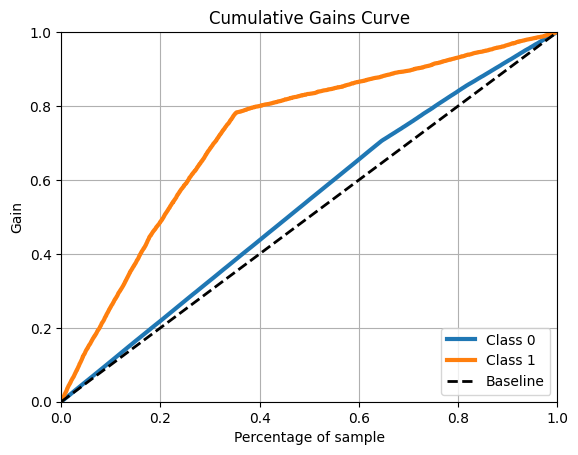

In [50]:
# KNN
model_knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_ml, y_train_ml) # fitting the model

y_hat_knn = model_knn.predict_proba(X_val) # getting the probabilities 

plot_cumulative_gain(y_validation, y_hat_knn); # plotting the cumulative gain curve

In [51]:
model_knn_cv = KNeighborsClassifier(n_neighbors=5).fit(X_train_ml, y_train_ml)
cv_knn = cross_validation(model_knn_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.2. **Logistic Regression**

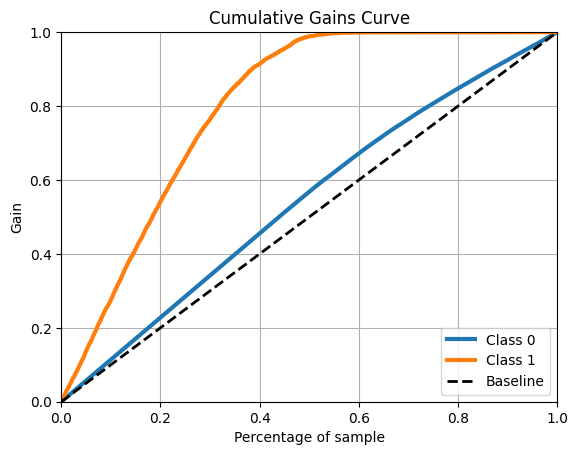

In [52]:
# Logistic Regression
model_lr = LogisticRegression(random_state=42).fit(X_train_ml, y_train_ml) # fitting the model

y_hat_lr = model_lr.predict_proba(X_val) # getting the probabilities 

plot_cumulative_gain(y_validation, y_hat_lr); # plotting the cumulative gain curve

In [53]:
model_lr_cv = LogisticRegression(random_state=42)

cv_lr = cross_validation(model_lr_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.3. **Random Forest**

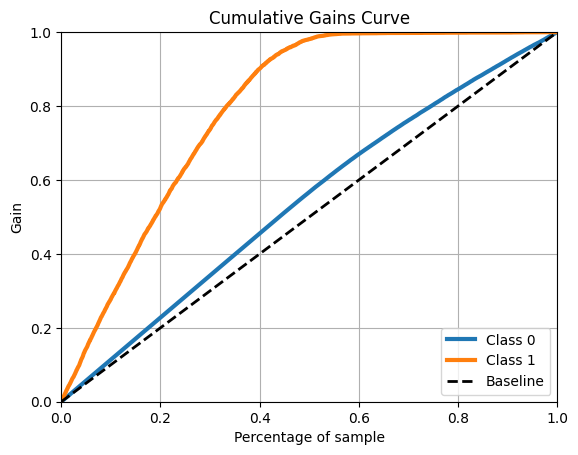

In [54]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=250,
                                  random_state=42).fit(X_train_ml, y_train_ml) # fitting the model
              
y_hat_rf = model_rf.predict_proba(X_val) # getting the probabilities 

plot_cumulative_gain(y_validation, y_hat_rf); # plotting the cumulative gain curve

In [55]:
model_rf_cv = RandomForestClassifier(n_estimators=250,
                                     random_state=42)
cv_rf = cross_validation(model_rf_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.4. **AdaBoost**

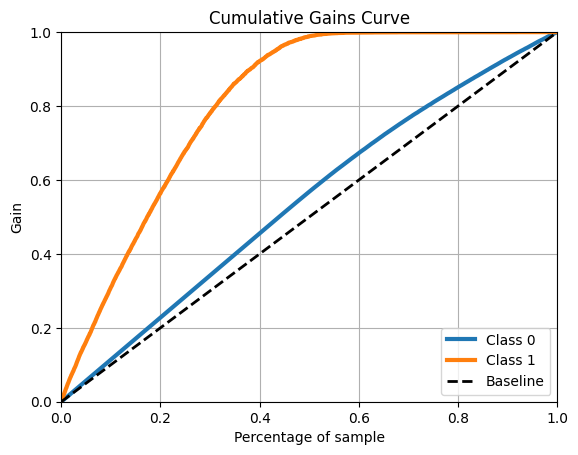

In [56]:
# AdaBoost
model_ada = AdaBoostClassifier(n_estimators=250,
                               random_state=42).fit(X_train_ml, y_train_ml) # fitting the model
              
y_hat_ada = model_ada.predict_proba(X_val) # getting the probabilities 

plot_cumulative_gain(y_validation, y_hat_ada); # plotting the cumulative gain curve

In [57]:
model_ada_cv = AdaBoostClassifier(n_estimators=250,
                                  random_state=42)
cv_ada = cross_validation(model_ada_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.5. **CatBoost**

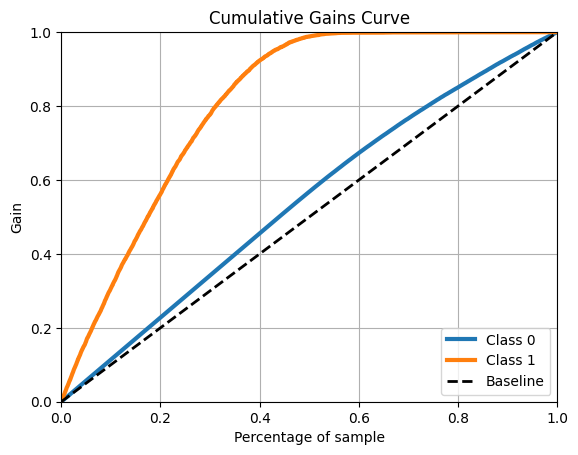

In [58]:
# CatBoost
model_cb = CatBoostClassifier(n_estimators=250,
                              verbose=False,
                              random_state=42).fit(X_train_ml, y_train_ml) # fitting the model
              
y_hat_cb = model_cb.predict_proba(X_val) # getting the probabilities 

plot_cumulative_gain(y_validation, y_hat_cb); # plotting the cumulative gain curve

In [59]:
model_cb_cv = CatBoostClassifier(n_estimators=250,
                                 verbose=False,
                                 random_state=42)
cv_cb = cross_validation(model_cb_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.6. **XGBoost**

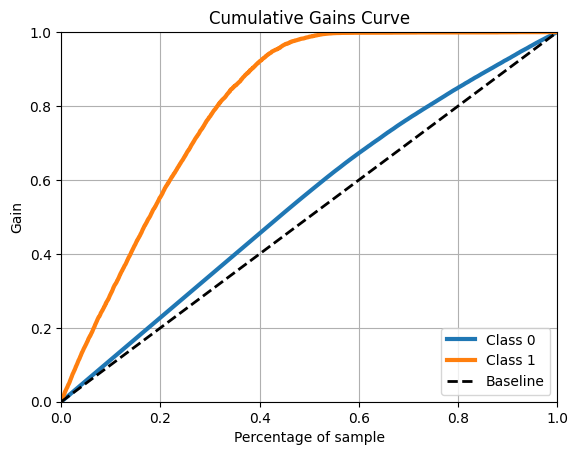

In [60]:
# XGBoost
model_xgb = XGBClassifier(n_estimators=250,
                          random_state=42).fit(X_train_ml, y_train_ml) # fitting the model
              
y_hat_xgb = model_xgb.predict_proba(X_val) # getting the probabilities 

plot_cumulative_gain(y_validation, y_hat_xgb); # plotting the cumulative gain curve

In [61]:
model_xgb_cv = XGBClassifier(n_estimators=250,
                             random_state=42)
cv_xgb = cross_validation(model_xgb_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.7. **Light GBM**

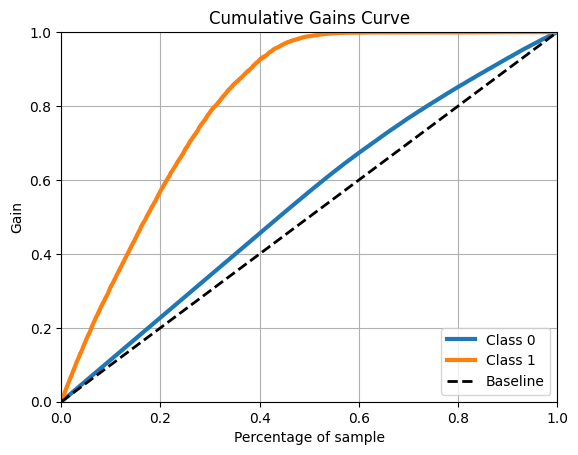

In [62]:
# Light GBM - Plot cumulative gain curve
model_lgbm = LGBMClassifier(n_estimators=250,
                            random_state=42).fit(X_train_ml, y_train_ml)
              
y_hat_lgbm = model_lgbm.predict_proba(X_val) # getting the probabilities 
plot_cumulative_gain(y_validation, y_hat_lgbm); # plotting the cumulative gain curve

In [63]:
# Light GBM - Cross Validation
model_lgbm_cv = LGBMClassifier(n_estimators=250,
                               random_state=42)
cv_lgbm = cross_validation(model_lgbm_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.8. **Comparing Models Performance**

In [64]:
models_performance = pd.concat([cv_rf, cv_knn, cv_lr, cv_cb, cv_xgb, cv_lgbm, cv_ada])
models_performance.sort_values('Precision at K', ascending=False)

,Model,Precision at K,Recall at K
0,LGBMClassifier,0.2789 +/- 0.0003,0.9329 +/- 0.001
0,AdaBoostClassifier,0.2783 +/- 0.0007,0.9309 +/- 0.0023
0,CatBoostClassifier,0.2783 +/- 0.0005,0.9311 +/- 0.0018
0,XGBClassifier,0.2771 +/- 0.0006,0.927 +/- 0.0022
0,LogisticRegression,0.2748 +/- 0.0009,0.9193 +/- 0.0031
0,RandomForestClassifier,0.2719 +/- 0.0005,0.9096 +/- 0.0016
0,KNeighborsClassifier,0.2392 +/- 0.0006,0.8001 +/- 0.0019


<p align="justify"> The <b>Light GBM Classifier</b> model will be chosen for hyperparameter tuning, since it's by far the fastest algorithm to train and tune, whilst being the one with best results without any tuning. </p>

LGBM speed in comparison to other ensemble algorithms trained in this dataset:
- 4.7 times faster than CatBoost 
- 7.1 times faster than XGBoost
- 30.6 times faster than AdaBoost
- 63.2 times faster than Random Forest

In [65]:
model_lgbm = LGBMClassifier(n_estimators=250,
                            random_state=42)

# Model Evaluation - Precision at K and Recall at K, K = 20,000 - Without cross-validation
lgbm_no_cross_first = model_eval(model_lgbm_cv, X_train_ml, y_train_ml, X_val, y_validation)
lgbm_no_cross_first

,Model,Precision at K,Recall at K
0,LGBMClassifier,0.30940,0.82790


<p align="justify"> At first glance the models performances don't look so great, and that's due to the short amount of variables, on which many are too categorical or binary, or simply those don't have much information content. 

However, <b>for this business problem</b> this isn't a major concern, since the goal here isn't finding the best possible prediction on whether a customer will buy the new insurance or not, but to <b>create a score that ranks clients in a ordered list, so that the sales team can contact them in order to sell the new vehicle insurance</b>.</p>

## 9. **Hyperparameter Fine Tuning**

#### 9.1. **Bayesian Optimization**

<p align="justify"> An important task in ML modeling is Hyperparameter Tuning, on which the goal is to find the <b>best possible combination of model hyperparameters</b>. One way of doing this is via Bayesian Optimization, by using the <a href="https://optuna.org/">Optuna</a> library. This is how it works:

- A set of possible model hyperparameters (search space) is defined.
  
- It starts searching random combinations of these parameters and training each model.
  
- Then, Optuna uses a history record of trials to determine which hyperparameter values to try next, by trying to find the most promising hyperparameters to be tuned.
  
- The metrics for each model are saved for latter comparison.

Bayesian Optimization is definitely more efficient in comparison to Grid Search and Random Search, since it's much faster than Grid Search, and it goes through better (smarter) hyperparameters combination than Random Search, meaning that it considers hyperparameters differently in terms of model impact. </p>

In [66]:
# # Defining an objective function to be optimized
# def bayesian_opt_objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 1000, 2500, step=100)
#     learning_rate = trial.suggest_float('learning_rate', 0.015, 0.30, step=0.005)
#     num_leaves = trial.suggest_int('num_leaves', 40, 200, step=5)
#     max_depth = trial.suggest_int('max_depth', 5, 12, step=1)
#     min_split_gain = trial.suggest_float('min_split_gain', 0.01, 0.1, step=0.005)
#     min_child_samples = trial.suggest_int('min_child_samples', 40, 120, step=5)
#     min_child_weight = trial.suggest_float('min_child_weight', 0.001, 0.0985, step=0.0025)
#     subsample = trial.suggest_float('subsample', 0.7, 1, step=0.05)
#     colsample_bytree = trial.suggest_float('colsample_bytree', 0.7, 1, step=0.05)
#     neg_bagging_fraction = trial.suggest_float('neg_bagging_fraction', 0.1, 0.9, step=0.05)
    
#     lgbm = LGBMClassifier(n_estimators = n_estimators,
#                           learning_rate = learning_rate, 
#                           num_leaves = num_leaves, 
#                           max_depth = max_depth,
#                           min_split_gain = min_split_gain,
#                           min_child_samples = min_child_samples,
#                           min_child_weight = min_child_weight,
#                           subsample = subsample,
#                           colsample_bytree = colsample_bytree,
#                           neg_bagging_fraction=neg_bagging_fraction,
#                           random_state=42).fit(X_train_ml, y_train)

#     yhat_lgbm_proba = lgbm.predict_proba(X_val)
        
#     data = X_val.copy()
#     data['response'] = y_validation.copy()
#     data['score'] = yhat_lgbm_proba[:,1].tolist()

#     data = data.sort_values('score',ascending=False)

#     recall_k_20000 = recall_at_k(data)

#     return recall_k_20000

In [67]:
# study = optuna.create_study(direction='maximize') # maximizing the precision at k
# study.optimize(bayesian_opt_objective, n_trials=1500); # optimizing the defined function and setting the number of trials
# trial = study.best_trial

# print(f'Best Recall at K = {trial.value}')
# print(f'Best Hyperparameters = {trial.params}')

#### 9.2. **Final Model**

Out of the tested hyperparameters, Bayesian Optimization with Optuna provided the following as the best ones:

| Hyperparameter | Definition | Best Value |
|:---:|---|:---:|
| n_estimators | Number of boosting iterations | 2400 |
| learning_rate | Shrinkage rate | 0.07 |
| num_leaves | Max number of leaves in one tree | 90 |
| max_depth | Limit the max depth for tree model | 5 |
| min_split_gain |Minimum loss reduction required to make a further partition on a leaf node of the tree |0.08 |
| min_child_samples | Minimal number of data in one leaf | 75 |
| min_child_weight | Minimal sum hessian in one leaf | 0.065 |
| subsample | Used to randomly select part of data without resampling| 0.95 |
| colsample_bytree| Used to randomly select a subset of features on each iteration| 0.75 |
| neg_bagging_fraction| Used for imbalanced binary classification problem, will randomly sample negative samples in bagging| 0.3 |

In [68]:
# Tuned Parameters
best_param = {
'n_estimators': 2400, 
'learning_rate': 0.07, 
'num_leaves': 90, 
'max_depth': 5, 
'min_split_gain': 0.08, 
'min_child_samples': 75, 
'min_child_weight': 0.065,
'subsample': 0.95, 
'colsample_bytree': 0.75, 
'neg_bagging_fraction': 0.3}

# Final Model
model_lgbm_final = LGBMClassifier(**best_param, random_state = 42)

lgbm_cross_final = cross_validation(model_lgbm_final, X_train_ml, y_train, 5, verbose=False)
lgbm_no_cross_final = model_eval(model_lgbm_final, X_train_ml, y_train_ml, X_val, y_validation)

pickle.dump(model_lgbm_final, open('model/model_insuricare.pkl', 'wb'))  # Saving for deployment

In [69]:
lgbm_cross_final # Model Evaluation on Validation dataset - Cross Validation - Final Model

,Model,Precision at K,Recall at K
0,LGBMClassifier,0.2793 +/- 0.0005,0.9344 +/- 0.0017


In [70]:
lgbm_no_cross_final # Model Evaluation on Validation dataset - Without Cross Validation - Final Model

,Model,Precision at K,Recall at K
0,LGBMClassifier,0.31130,0.83320


With or without cross-validation the model has improved in comparison to the original model, on which the only parameter was n_estimators = 250.

#### 9.3. **Ordered List for all 76 thousand new customers**

In order to provide a list with all 76 thousand new customers ranked by propensity score the df_test dataset has to go through all transformations df_train went through. 

In [71]:
data_shape(x_test)

Number of Rows: 76222
Number of Columns: 11


In [72]:
# Data Cleaning
x_test['region_code'] = x_test['region_code'].astype(str)
x_test['policy_sales_channel'] = x_test['policy_sales_channel'].astype(str)

# Feature Engineering
x_test['vehicle_damage'] = x_test['vehicle_damage'].apply(lambda x: 0 if x=='No' else 1)

# Data Preparation
# rescaling
x_test['age'] = mms_age.transform(x_test[['age']].values)
x_test['vintage'] = mms_vintage.transform(x_test[['vintage']].values)
x_test['annual_premium'] = rs.transform(x_test[['annual_premium']].values)
# encoding
x_test = pd.get_dummies(x_test, prefix=['gender'], columns=['gender']).rename(columns={'gender_Female': 'female', 'gender_Male': 'male'})
x_test = pd.get_dummies(x_test, prefix=['vehicle_age'], columns=['vehicle_age']).rename(columns={'vehicle_age_< 1 Year' : 'v_age_below_1_year', 'vehicle_age_1-2 Year': 'v_age_between_1_2_years', 'vehicle_age_> 2 Years': 'v_age_above_2_years'})
x_test = x_test.assign(region_code=x_test['region_code'].map(te_region_code))
x_test = x_test.assign(policy_sales_channel=x_test['policy_sales_channel'].map(te_policy_sales_channel))

# Feature Selection
x_test_ml = x_test[cols_selected]
y_test_ml = y_test.copy()

But before getting the ordered list, it's important to check model performance on new data:

In [73]:
lgbm_final_76k = model_eval(model_lgbm_final, X_train_ml, y_train_ml, x_test_ml, y_test_ml)
lgbm_final_76k

,Model,Precision at K,Recall at K
0,LGBMClassifier,0.33260,0.71210


Recall at 20,000 equal to 0.7129 means that if Insuricare Sales Team makes 20,000 calls they will be able to reach out 71,29% of interested customers. The in-depth results are shown in the **next section**.

In [74]:
# Getting the ordered list
insuricare_list = propensity_score(model_lgbm_final, x_test_ml, df_test)   
# insuricare_list.to_excel('insuricare_list.xlsx', index=False) # Exporting the list

insuricare_list

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,score
129900,275952,Male,30,8.0,155.0,1,1-2 Year,Yes,0,51282.00000,299,0.68828
268511,239842,Male,33,36.0,155.0,1,1-2 Year,Yes,0,27441.00000,281,0.65730
174074,247721,Male,39,10.0,157.0,1,1-2 Year,Yes,0,82533.00000,52,0.63452
133063,301620,Male,34,44.0,163.0,1,1-2 Year,Yes,0,27607.00000,281,0.61939
155479,99106,Male,32,41.0,163.0,1,1-2 Year,Yes,0,23462.00000,241,0.61430
...,...,...,...,...,...,...,...,...,...,...,...,...
112529,136389,Female,78,15.0,152.0,1,1-2 Year,No,1,25747.00000,156,0.00003
313477,219004,Male,72,50.0,18.0,1,1-2 Year,No,1,44368.00000,250,0.00003
347984,115393,Male,73,46.0,95.0,1,1-2 Year,No,1,21413.00000,238,0.00003
173142,240872,Male,78,15.0,152.0,1,1-2 Year,No,1,49631.00000,257,0.00003


## 10. **Results**

- The LGBM model will be used to provide a ranked list of customers, from the most likely customer to buy the new vehicle insurance to the least likely.
- Insuricare will call the $K_{th}$ customers in the ranked list, with K being either 20,000 or 40,000, given the business problem.
- For evaluating the final model not only Precision at K, Recall at K and Cumulative Gain Curve will be calculated, but also the Lift Curve, which indicates how many times the ML model is better than the baseline model (original model used by Insuricare).

#### 10.1. **Business Results**

**1) By making 20,000 calls how many interested customers can Insuricare reach with the new model?**

In [75]:
recall_at_20k = lgbm_final_76k.values[0][2]
data_pct_20k = 20000 / len(x_test)

print(f'Data percentage that represents 20,000 calls = {round(data_pct_20k*100, 2)}%')
print(f'Amount of interested customers we can reach with 20,000 calls = {round(recall_at_20k*100,2)}%')

Data percentage that represents 20,000 calls = 26.24%
Amount of interested customers we can reach with 20,000 calls = 71.21%


<p align="justify"> 

- It's important to remember that the Cumulative Gains Curve indicates the percentage of customers (x axis), ordered by probability score, with the percentage of all customers interested in the new insurance (y axis). 

- 20,000 calls represents 26.24% of our database. So if the sales team were to make all these calls Insuricare would be able to contact 71.29% of customers interested in the new vehicle insurance, since 0.7129 is our recall at 20,000. </p>

(<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>,
 <AxesSubplot: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>)

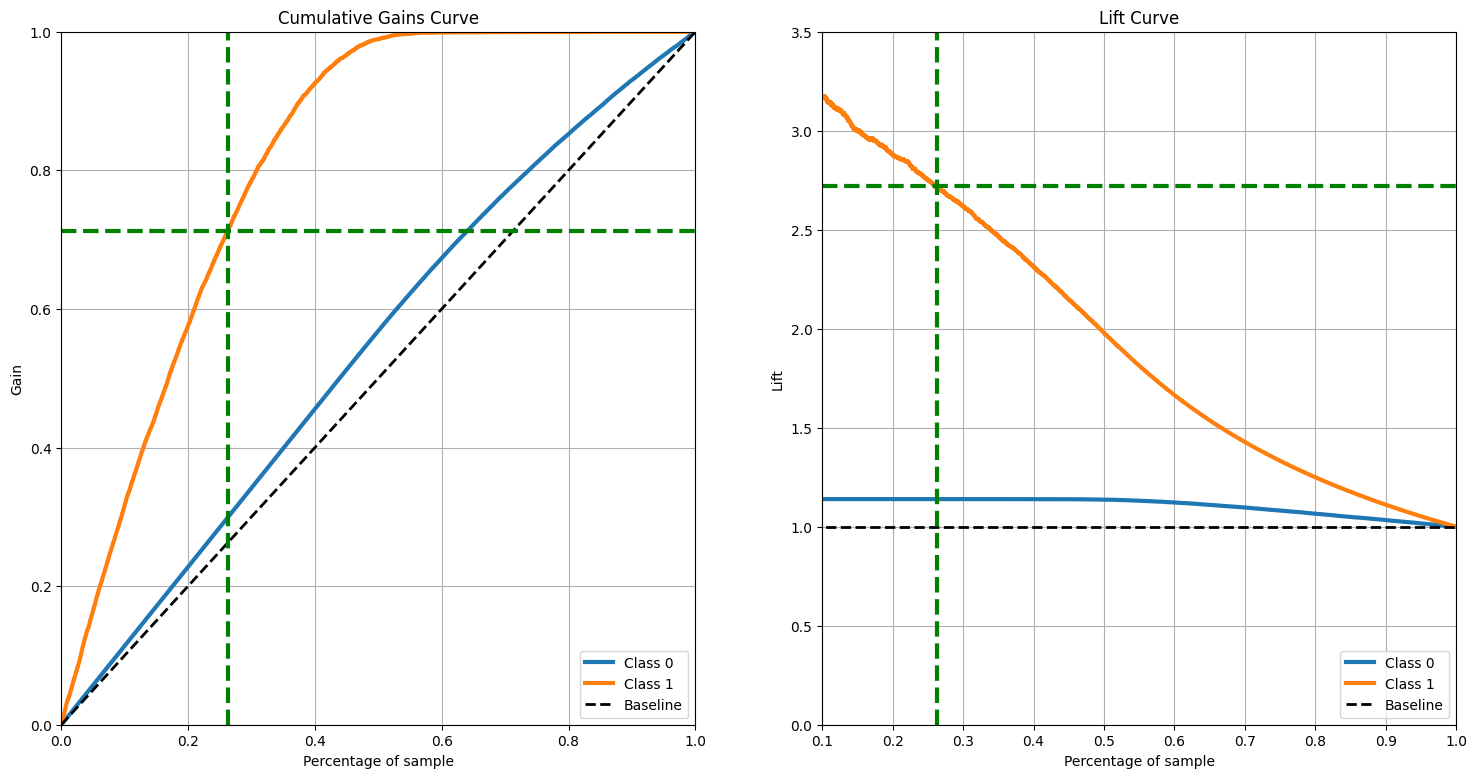

In [76]:
# Cumulative Gain Curve and Lift Curve - K = 20,000
model_curves(model_lgbm_final, X_train_ml, y_train_ml, x_test_ml, y_test_ml)

- The Lift Curve indicates how many times the ML model is better than the baseline model. In this case, our **LGBM model is around 2.72 times better than the model previously used by Insuricare.** 

**2) Now increasing the amount of calls to 40,000 how many interested customers can Insuricare reach with the new model?**

In [77]:
lgbm_final_76k_k40 = model_eval(model_lgbm_final, X_train_ml, y_train_ml, x_test_ml, y_test_ml, k=40000)
lgbm_final_76k_k40            

,Model,Precision at K,Recall at K
0,LGBMClassifier,0.23240,0.99500


In [78]:
recall_at_40k = lgbm_final_76k_k40.values[0][2]
data_pct_40k = 40000 / len(x_test)

print(f'Data percentage that represents 40,000 calls = {round(data_pct_40k*100, 2)}%')
print(f'Amount of interested customers we can reach with 40,000 calls = {round(recall_at_40k*100,2)}%')

Data percentage that represents 40,000 calls = 52.48%
Amount of interested customers we can reach with 40,000 calls = 99.5%


- 40,000 calls represents 52.48% of our database. So if the sales team were to make all these calls Insuricare would be able to contact 99.48% of customers interested in the new vehicle insurance, since 0.9948 is our recall at 40,000. 

(<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>,
 <AxesSubplot: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>)

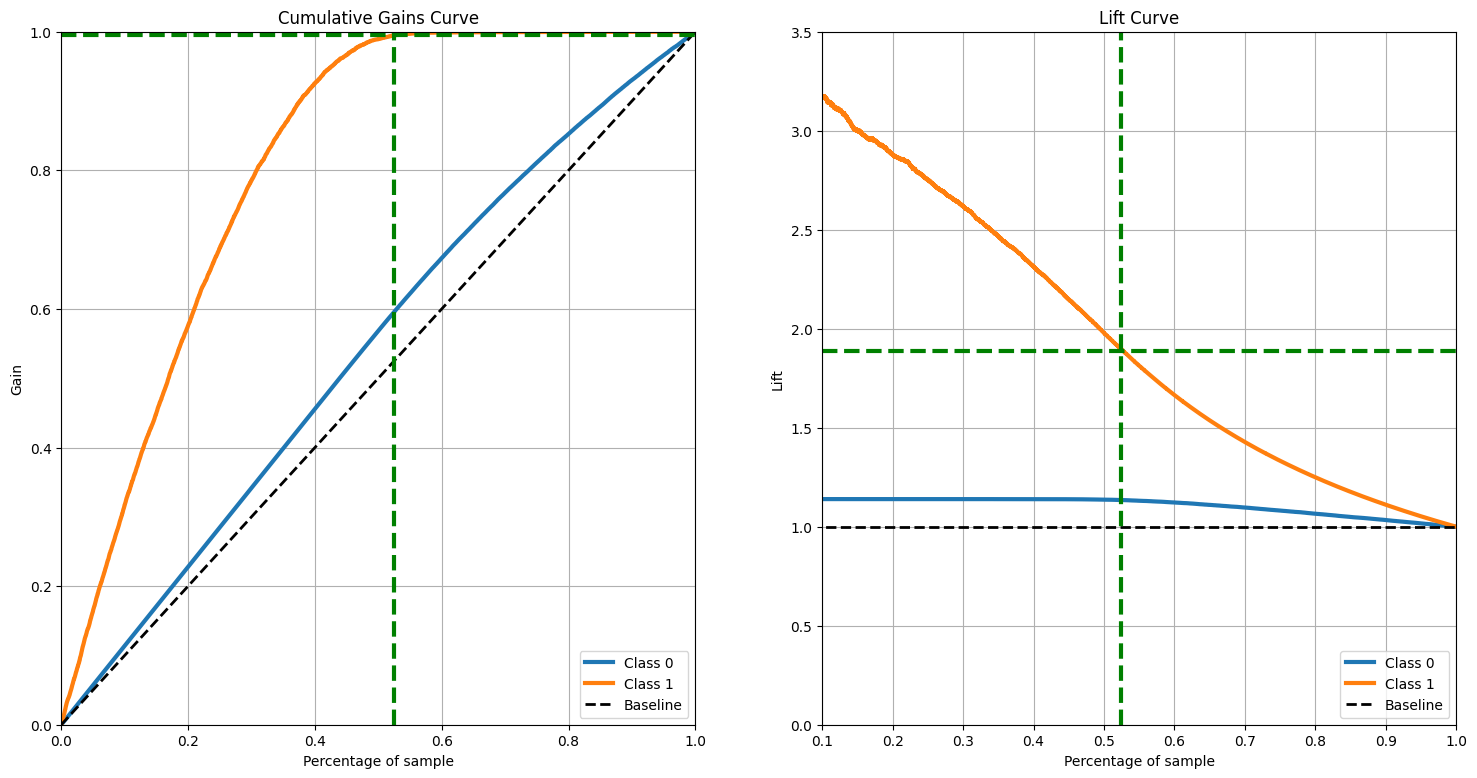

In [80]:
# Cumulative Gain Curve and Lift Curve - K = 40,000
model_curves(model_lgbm_final, X_train_ml, y_train_ml, x_test_ml, y_test_ml, k=40000, axh=0.9948, axh_lift=1.89)

- At 40,000 calls, our **LGBM model is around 1.89 times better than the model previously used by Insuricare.**  

#### 10.2. **Expected Financial Results**

In [81]:
pct_interested_people_305k = y_train.value_counts()[1]/len(y_train)
print(f'Out of the 305 thousand people that took the survey, around {round(pct_interested_people_305k*100,2)}% want the new insurance.')

Out of the 305 thousand people that took the survey, around 12.26% want the new insurance.


To make a financial results estimative of our model, let's consider a few assumptions:

- The customer database that will be reached out is composed of 76,222 clients.
- We expect 12.28% of these customers to be interested in the new vehicle insurance, since it's the percentage of interest people that participated in the Insuricare research. 
- The annual premium for each of these new vehicle insurance customers is US$ 2,630 yearly. **
  
** <i> The annual premium of US$ 2,630 is set for realistic purposes, since it's the lowest and most common value in the whole dataset. </i>

In [82]:
interested_people_76k = pct_interested_people_305k*len(y_test)
response_yes = round(interested_people_76k) # Expected amount of people interested in the new vehicle insurance
response_yes

9342

10.2.1. **Financial results for 20,000 calls**

In [83]:
baseline_model_20k = round(response_yes*(data_pct_20k)) # Expected amount of customers reached out by the baseline model - 20k calls
lgbm_model_20k = round(response_yes*(recall_at_20k)) # Expected amount of customers reached out by the lgbm model - 20k calls

print(f'Amount of interested clients reached out by the Baseline Model : {baseline_model_20k} of {response_yes} interested clients, by making 20,000 calls.')
print(f'Amount of interested clients reached out by the LGBM Model : {lgbm_model_20k} of {response_yes} interested clients, by making 20,000 calls.')

print(f'Amount of interested clients difference between both models : {lgbm_model_20k - baseline_model_20k}, by making 20,000 calls')

Amount of interested clients reached out by the Baseline Model : 2451 of 9342 interested clients, by making 20,000 calls.
Amount of interested clients reached out by the LGBM Model : 6652 of 9342 interested clients, by making 20,000 calls.
Amount of interested clients difference between both models : 4201, by making 20,000 calls


In [84]:
baseline_revenue_20k = baseline_model_20k*2630 # Expected annual revenue -  baseline model - 20k calls
lgbm_revenue_20k = lgbm_model_20k*2630 # Expected annual revenue -  lgbm model - 20k calls

print(f'Total annual revenue using the Baseline Model, by making 20,000 calls = US$ {baseline_revenue_20k:,.2f}')
print(f'Total annual revenue using the LGBM Model, by making 20,000 calls = US$ {lgbm_revenue_20k:,.2f}')

print(f'Annual revenue difference between both models, by making 20,000 calls = US$ {lgbm_revenue_20k - baseline_revenue_20k:,.2f}')

Total annual revenue using the Baseline Model, by making 20,000 calls = US$ 6,446,130.00
Total annual revenue using the LGBM Model, by making 20,000 calls = US$ 17,494,760.00
Annual revenue difference between both models, by making 20,000 calls = US$ 11,048,630.00


|    **Model**    | **Annual Revenue - 20,000 calls** | **Interested clients reached out - 20,000 calls** |
|:---------------:|:-----------------------------------:|:---------------------------------------:|
|       LGBM      |            US$ 17,515,800.00        |                   6660                  |
|     Baseline    |            US$ 6,446,130.00         |                   2451                  |
| $\Delta$ (LGBM, Baseline) |            US$ 11,069,670.00        |             4209                  |

10.2.2. **Financial results for 40,000 calls**

In [85]:
baseline_model_40k = round(response_yes*(data_pct_40k)) # Expected amount of customers reached out by the baseline model - 40k calls
lgbm_model_40k = round(response_yes*(recall_at_40k)) # Expected amount of customers reached out by the lgbm model - 40k calls

print(f'Amount of interested clients reached out by the Baseline Model : {baseline_model_40k} of {response_yes} interested clients, by making 40,000 calls.')
print(f'Amount of interested clients reached out by the LGBM Model : {lgbm_model_40k} of {response_yes} interested clients, by making 40,000 calls.')

print(f'Amount of interested clients difference between both models : {lgbm_model_40k - baseline_model_40k}, by making 40,000 calls')

Amount of interested clients reached out by the Baseline Model : 4903 of 9342 interested clients, by making 40,000 calls.
Amount of interested clients reached out by the LGBM Model : 9295 of 9342 interested clients, by making 40,000 calls.
Amount of interested clients difference between both models : 4392, by making 40,000 calls


In [86]:
baseline_revenue_40k = baseline_model_40k*2630 # Expected annual revenue -  baseline model - 40k calls
lgbm_revenue_40k = lgbm_model_40k*2630 # Expected annual revenue -  lgbm model - 40k calls

print(f'Total annual revenue using the Baseline Model, by making 40,000 calls = US$ {baseline_revenue_40k:,.2f}.')
print(f'Total annual revenue using the LGBM Model, by making 40,000 calls = US$ {lgbm_revenue_40k:,.2f}.')

print(f'Annual revenue difference between both models, by making 40,000 calls = US$ {lgbm_revenue_40k - baseline_revenue_40k:,.2f}.')

Total annual revenue using the Baseline Model, by making 40,000 calls = US$ 12,894,890.00.
Total annual revenue using the LGBM Model, by making 40,000 calls = US$ 24,445,850.00.
Annual revenue difference between both models, by making 40,000 calls = US$ 11,550,960.00.


|    **Model**    | **Annual Revenue - 40,000 calls** | **Interested clients reached out - 40,000 calls** |
|:---------------:|:-----------------------------------:|:---------------------------------------:|
|       LGBM      |            US$ 24,440,590.00        |                   9293                  |
|     Baseline    |            US$ 12,894,890.00        |                   4903                  |
| $\Delta$ (LGBM, Baseline) |            US$ 11,545,700.00        |            4390                  |

10.2.3. **Total Financial Results**

|    **Model**    |  **Annual Revenue - 20,000 calls** | **Annual Revenue - 40,000 calls** |  **Interested clients reached out - 20,000 calls** | **Interested clients reached out - 40,000 calls** |
|:---------------:|:---:|:-----------------------------------:|:---:|:---------------------------------------:|
|       LGBM      | US$ 17,515,800.00    |US$ 24,440,590.00          | 6660   |9293                  |
|     Baseline    |  US$ 6,446,130.00    |US$ 12,894,890.00           | 2451  |4903                  |
| $\Delta$ (LGBM, Baseline) |  11,069,670.00     |US$ 11,545,700.00         |  4209   |   4390                  |

As seen above the LGBM model can provide much better results in comparison to the baseline model, with an annual financial result around 172% better for 20,000 calls and 89% better for 40,000 calls, which is exactly what was shown in the Lift Curve.

## 12. **Conclusion and Next Steps**

In this project the main objective was accomplished:

 <p align="justify"> <b> We managed to provide a list of new customers ordered by their buy propensity score and a spreadsheet that returns the buy propensity score for other new future customers. Now, the Sales Team can focus their attention on the 20,000 or 40,000 first customers on the list, and in the future focus on the top K customers of the new list. </b> In addition to that, five interesting and useful insights were found through Exploratory Data Analysis (EDA), so that those can be properly used by Insuricare, as well as Expected Financial Results. </p>
 
<p align="justify"> Further on, this solution could be improved by a few strategies:
  
 - Conducting more market researches, so that more useful information on customers could be collected, since there was a lack of meaningful variables.
  
 - Applying <a href="https://builtin.com/data-science/step-step-explanation-principal-component-analysis">Principal Component Analysis (PCA) </a> in the dataset.
  
 - Try other classification algorithms that could better capture the phenomenon.